In [1]:
import os
import numpy as np
from scipy.io import loadmat
from numpy.linalg import matrix_power
from numpy.linalg import eig
from numpy.linalg import matrix_rank
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import time
from control import ctrb

 Data and SSM Acquisition

In [2]:
os.chdir(r'C:\Users\13905\Downloads')
fRHdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\forecastRH15min.csv')) # Forecasted Relative Humidity 15 minute data
rRHdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\realmeasuredRH15min.csv')) # Real Measured Relative Humidity 15 minute data
fTdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\forecastTemp15min.csv')) # Forecasted Temperature 15 minute data
rTdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\realmeasuredTemp15min.csv')) # Real Measured Temperature 15 minute data

#fRHdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\forecastRH15min_2019.csv')) # Forecasted Relative Humidity 15 minute data
#rRHdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\realRH15min_2019.csv')) # Real Measured Relative Humidity 15 minute data
#fTdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\forecastT15min_2019.csv')) # Forecasted Temperature 15 minute data
#rTdata = np.asarray(pd.read_csv(r'C:\Users\13905\Downloads\realT15min_2019.csv')) # Real Measured Temperature 15 minute data

fRHdata[:len(rRHdata),0] = rRHdata[:,0]
#fTdata[:len(rTdata),0] = rTdata[:,0]

os.chdir(r'C:\Users\13905\Desktop\Research\Humidity Formulation')
matrices = loadmat('FullSSM3.mat')
A = np.asarray(matrices['A_full'])
B = np.asarray(matrices['B_full'])
Bu = B[:,:8]
Bu = np.hstack([Bu, -Bu[:,2:]])
#cooling = -B[:,0:1]
#Bu = np.hstack([B[:,0:1],cooling,B[:,[1,4,5,6,7,8,9,10,11,12,13,14,15]]])
Bv = B[:,8:] # Ambient Temperature, Ground Temperature, Ambient Relative Humidity, 2 rows of disturbance data
Uwidth = Bu.shape[1]
Vwidth = Bv.shape[1]

In [3]:
matrix_rank(ctrb(A,Bu))

30

In [4]:
def horizon_fA(A,H):
    A_h = A
    if (H <= 1):
        return A_h
    else:
        for i in range(1,H):
            new_A = matrix_power(A, i+1)
            A_h = np.concatenate((A_h,new_A))
        return A_h

def horizon_fB(A,B,H):
    lenB = B.shape[0]
    widB = B.shape[1]

    B_h = np.zeros((lenB*H,widB*H))

    for i in range(0,H):
        for j in range(0,i+1):
            B_h[i*lenB:(i+1)*lenB,j*widB:(j+1)*widB] = matrix_power(A,i-j)@B
    return B_h
H = 5 # Prediction Horizon
A_MPC = horizon_fA(A,H)
Bu_MPC = horizon_fB(A,Bu,H)
Bv_MPC = horizon_fB(A,Bv,H)

In [5]:
def deterministic(H,A_MPC,Bu_MPC,Bv_MPC,input_v,x):
    cost = np.ones((1,14))
    cost[0,:2] = 5
    cost[0,2:8] = 10
    cost[0,8:] = 10
    c = np.kron(np.ones((1,H)),cost)
    lenU = Bu.shape[0]
    widthU = Bu.shape[1]
    x_const_upper = np.zeros((30*H,1))
    for a in range(H):  
        x_const_upper[a * 30 + 1: a * 30 + 6, 0] = 25
        x_const_upper[a* 30 + 25: a * 30 + 30, 0] = 0.6    

    x_const_lower = np.zeros((30*H,1))
    for a in range(H):  
        x_const_lower[a * 30 + 1: a * 30 + 6, 0] = 15
        x_const_lower[a* 30 + 25: a * 30 + 30, 0] = 0.3 # Set the lower limits for Zone's Relative Humidity
    u = cp.Variable((widthU*H,1),nonneg=True)
    xnew = cp.Variable((lenU*H,1))
    eta = cp.Variable((30*H,1))
    s = np.eye(30)
    for i in range(1,6):
        s[i,i] = 100
    for i in range(-5,0):
        s[i,i] = 1e8
    S = np.kron(np.eye(H),s)
    objective = cp.Minimize(cp.sum(c@u) + cp.sum(cp.quad_form(eta,S)))
    constraints = []
    constraints += [
        xnew == A_MPC@x + Bu_MPC@u + Bv_MPC@input_v
    ]
    constraints += [
        xnew <= x_const_upper + eta,
        xnew >= x_const_lower - eta,
    ]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='GUROBI',verbose=True)
    u_h = u.value
    return u_h

In [6]:
x0 = np.ones([30,1])*21
x0[-6:,:] = 0.4
simHorizon = 673
x = np.zeros((30,simHorizon))
x[:,0:1] = x0
U = np.zeros((Uwidth,simHorizon))
error = 0
startIndex = 14011            # Starting with the date (Nov 1st 0:00, 2016) to (Nov 7th 23:45, 2016)
#startIndex = 2208
start = time.time()
for i in range(0,simHorizon-1):
    input_v = np.zeros((Bv_MPC.shape[1],1))
    for j in range(0,H):
        input_v[j*Vwidth,0] = fTdata[i + startIndex,j]
        input_v[j*Vwidth+1,0] = 18
        input_v[j*Vwidth+2,0] = fRHdata[i + startIndex,j]
    ## Ideal Condition

   # out_info = np.zeros((Vwidth,1))
   # out_info[0,0] = fTdata[i + startIndex,0]
   # out_info[1,0] = 18
   # out_info[2,0] = fRHdata[i + startIndex,0]
    
    ## Real Condition

    out_info = np.zeros((Vwidth,1))
    out_info[0,0] = rTdata[i + startIndex,0]
    out_info[1,0] = 18
    out_info[2,0] = rRHdata[i + startIndex,0]

    currentIndex = startIndex + i
    u_h = deterministic(H,A_MPC,Bu_MPC,Bv_MPC,input_v,x[:,i:i+1])
    if u_h is None:
        u = np.ones((Uwidth,1)) * 200
        #for k in range(-5,0):
        #    if x[k,i] > 0.5:
        #        u[[4,6,8,10,12]] = 0
        #    elif x[k,i] < 0.3:
        #        u[[5,7,9,11,13]] = 0
        error += 1
    else:
        u = u_h[:Uwidth]
    x[:,i+1:i+2] = A@x[:,i:i+1] + Bu@u + Bv@out_info
    U[:,i:i+1] = u
    for j in range(-5,0):
        if x[j,i] > 1:
            x[j,i] = 1
        elif x[j,i] < 0:
            x[j,i] = 0

Using license file C:\Users\13905\gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x37b65ae8
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.02s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms

Model fingerprint: 0xd9f21b7d
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.85577019e+08 -3.50833282e+08  8.33e+03 2.59e+03  5.80e+06     0s
   1   1.42228778e+08 -9.15729105e+07  9.76e+01 5.37e+01  6.79e+05

Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.12108838e+08 -3.68797145e+08  8.55e+03 2.69e+03  5.95e+06     0s
   1   1.45657359e+08 -9.37075932e+07  9.89e+01 5.52e+01  6.94e+05     0s
   2   1.86921139e+07 -1.74631243e+07  2.21e-02 2.86e-02  9.64e+04     0s
   3   3.11848063e+06 -2.96672788e+06  1.48e-03 1.92e-03  1.62e+04     0s
   4   6.00483751e+05 -4.85462337e+05  4.27e-08 2.72e-06  2.90e+03     0s
   5   1.23403113e+05 -1.24835735e+04  4.39e-10 5.31e-08  3.62e+02     0s
   6   5.29879648e+04  3.44724213e+04  1.65e-11 2.82e-09  4.94e+01     0s
   7   4.48556311e+04  4.16272968e+04  3.62e-11 4.22e-09 

   1   1.48829399e+08 -9.56753450e+07  1.00e+02 5.65e+01  7.09e+05     0s
   2   1.92145030e+07 -1.78870098e+07  4.55e-02 5.95e-02  9.90e+04     0s
   3   3.26371727e+06 -3.07624203e+06  3.86e-03 5.04e-03  1.69e+04     0s
   4   6.21055238e+05 -5.05492278e+05  3.32e-08 2.81e-06  3.00e+03     0s
   5   1.27960091e+05 -1.42564291e+04  4.12e-10 5.89e-08  3.79e+02     0s
   6   5.47712441e+04  3.44695126e+04  4.60e-11 7.61e-09  5.41e+01     0s
   7   4.55212802e+04  4.21540164e+04  1.62e-11 3.79e-09  8.98e+00     0s
   8   4.44536684e+04  4.37812744e+04  4.25e-12 7.19e-10  1.79e+00     0s
   9   4.42116985e+04  4.41556959e+04  3.12e-12 3.32e-10  1.49e-01     0s
  10   4.41866320e+04  4.41829549e+04  1.80e-10 2.51e-09  9.81e-03     0s
  11   4.41849830e+04  4.41848745e+04  1.09e-11 4.91e-10  2.89e-04     0s
  12   4.41849366e+04  4.41849340e+04  1.13e-13 5.42e-12  6.80e-06     0s
  13   4.41849359e+04  4.41849354e+04  5.91e-14 1.86e-11  1.38e-06     0s
  14   4.41849357e+04  4.41849357e+04 

   5   1.28400975e+05 -1.71680941e+04  5.61e-10 6.22e-08  3.88e+02     0s
   6   5.17638758e+04  3.35019635e+04  1.83e-10 4.40e-09  4.87e+01     0s
   7   4.39618265e+04  4.12584923e+04  3.55e-15 1.82e-12  7.21e+00     0s
   8   4.29487487e+04  4.27870287e+04  2.85e-12 6.22e-11  4.31e-01     0s
   9   4.28785070e+04  4.28727338e+04  3.90e-11 9.77e-10  1.54e-02     0s
  10   4.28759302e+04  4.28753320e+04  9.43e-12 1.43e-10  1.60e-03     0s
  11   4.28756360e+04  4.28756269e+04  5.04e-14 2.87e-12  2.41e-05     0s
  12   4.28756315e+04  4.28756314e+04  3.55e-15 9.09e-13  2.18e-07     0s
  13   4.28756314e+04  4.28756314e+04  2.22e-15 9.09e-13  2.59e-08     0s
  14   4.28756314e+04  4.28756314e+04  3.55e-15 9.09e-13  6.25e-10     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 4.28756314e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of para

  11   4.78953961e+04  4.78953236e+04  1.71e-12 5.59e-10  1.93e-04     0s
  12   4.78953605e+04  4.78953571e+04  9.77e-14 4.35e-11  9.04e-06     0s
  13   4.78953587e+04  4.78953585e+04  4.44e-15 1.89e-11  5.08e-07     0s
  14   4.78953586e+04  4.78953586e+04  3.55e-15 9.09e-13  9.51e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 4.78953586e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x7672d9cf
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e

Optimal objective 4.93344788e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x97550ee0
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.29756486e+08 -4.50017402e+08  9.48e+03 3.12e+03  6.57e+06     0s
   1   1.59990758e+08 -1.02566524e+08  1.04e+02 6.10e+01  7.58e+05     0s
   2   2.29506784e+07 

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.49652433e+08 -4.63899981e+08  9.63e+03 3.19e+03  6.67e+06     0s
   1   1.62328473e+08 -1.03986818e+08  1.05e+02 6.19e+01  7.69e+05     0s
   2   2.33477148e+07 -2.16269043e+07  3.19e-02 4.35e-02  1.20e+05     0s
   3   4.10849560e+06 -3.84670182e+06  3.17e-03 4.33e-03  2.12e+04     0s
   4   8.66649978e+05 -7.47076214e+05  5.88e-08 3.49e-06  4.30e+03     0s
   5   1.68760787e+05 -2.69412336e

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.69581955e+08 -4.77937242e+08  9.78e+03 3.26e+03  6.77e+06     0s
   1   1.64599369e+08 -1.05374689e+08  1.06e+02 6.28e+01  7.79e+05     0s
   2   2.37366042e+07 -2.19567317e+07  4.20e-02 5.76e-02  1.22e+05     0s
   3   4.14397205e+06 -3.87649959e+06  4.10e-03 5.63e-03  2.14e+04     0s
   4   8.80562239e+05 -7.59020939e+05  6.68e-08 3.51e-06  4.37e+03     0s
   5   1.71740746e+05 -2.66800693e+04  1.15e-08 9.37e-08  5.29e+02     0s
   6   7.35276209e+04  4.36978356e+04  7.10e-12 2.04e-09  7.95e+01     0s
   7   6.10728466e+04  5.69315135e+04  1.07e-13 3.19e-11  1.10e+01     0s
   8   5.96047717e+04  5.89805906e+04  1.15e-14 2.90e-12  1.66e+00     0s
   9   5.93571659e+04  5.93024400e+04  3.55e-15 1.82e-12  1.46e-01     0s
  10   5.93396369e+04  5.93267030e+04  4.22e-15 9.09e-13  3.45e-02     0s
  11   5.93345688e+04  5.93342119e+04  4.88

   6   7.25735384e+04  4.58028385e+04  2.58e-11 4.86e-09  7.14e+01     0s
   7   6.17412076e+04  5.87489429e+04  5.25e-12 2.05e-09  7.98e+00     0s
   8   6.07001786e+04  6.03842654e+04  1.06e-13 4.18e-11  8.42e-01     0s
   9   6.05677732e+04  6.05452612e+04  4.88e-15 1.01e-12  6.00e-02     0s
  10   6.05604502e+04  6.05572277e+04  3.67e-12 1.68e-09  8.59e-03     0s
  11   6.05590275e+04  6.05590138e+04  4.80e-12 1.36e-09  3.66e-05     0s
  12   6.05590214e+04  6.05590204e+04  3.64e-13 1.06e-10  2.82e-06     0s
  13   6.05590209e+04  6.05590209e+04  4.88e-15 1.69e-12  1.31e-07     0s
  14   6.05590209e+04  6.05590209e+04  3.55e-15 9.09e-13  1.33e-10     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 6.05590209e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer

  14   6.56040838e+04  6.56040838e+04  4.89e-14 9.09e-13  2.65e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 6.56040838e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x24f2b183
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.25741016e+08 -5.17809630e+08  1.02e+04 3.45e+03  7.05e+06     0s
   1   1.70820630e+08 -1.09162317e+08  1.08e+02 6.52e+01  8.06e+05     0s
   2   2.48357801e+07 -2.28731636e+07  8.68e-02 1.21e-01  1.27e+05     0s
   3   4.61135497e+06 -4.30280323e+06  8.86e-03 1.24e-02  2.38e+04     0s
   4   1.06554182e+06 -9.39867173e+05  6

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.39646204e+08 -5.27740713e+08  1.03e+04 3.49e+03  7.12e+06     0s
   1   1.72328388e+08 -1.10076150e+08  1.08e+02 6.57e+01  8.13e+05     0s
   2   2.51133661e+07 -2.30994327e+07  1.03e-01 1.44e-01  1.29e+05     0s
   3   4.59994040e+06 -4.29227264e+06  1.01e-02 1.41e-02  2.37e+04     0s
   4   1.07037763e+06 -9.39341207e+05  5.73e-08 3.63e-06  5.36e+03     0s
   5   2.06229754e+05 -3.04041258e+04  1.20e-08 7.53e-08  6.31e+02     0s
   6   9.13416506e+04  5.81915881e+04  6.07e-13 9.17e-10  8.84e+01     0s
   7   7.72874882e+04  7.41889937e+04  6.02e-12 2.65e-09  8.26e+00     0s
   8   7.62655440e+04  7.58820045e+04  1.07e-14 2.06e-11  1.02e+00     0s
   9   7.60963078e+04  7.60833681e+04  3.77e-15 9.09e-13  3.45e-02     0s
  10   7.60912913e+04  7.60907397e+04  1.35e-11 1.83e-09  1.47e-03     0s
  11   7.60910276e+04  7.60910187e+04  1.15e-14 1.44e-11  2.38e-05     0s
  12   7.60910234e+04  7.60910230e+04 

  10   8.15851368e+04  8.15845554e+04  9.41e-12 1.57e-09  1.55e-03     0s
  11   8.15848562e+04  8.15848457e+04  1.33e-14 7.37e-12  2.80e-05     0s
  12   8.15848511e+04  8.15848509e+04  3.55e-15 1.82e-12  6.43e-07     0s
  13   8.15848510e+04  8.15848510e+04  4.00e-15 9.09e-13  1.91e-08     0s
  14   8.15848510e+04  8.15848510e+04  4.00e-15 9.09e-13  1.92e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 8.15848510e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x6e4db493
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xae4a15ea
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.78217791e+08 -5.55443304e+08  1.06e+04 3.62e+03  7.30e+06     0s
   1   1.76459717e+08 -1.12562823e+08  1.10e+02 6.75e+01  8.31e+05     0s
   2   2.58433621e+07 -2.36869642e+07  1.55e-01 2.19e-01  1.32e+05     0s
   3   4.58341513e+06 -4.27559945e+06  1.35e-02 1.91e-02  2.36e+04     0s
   4   1.09437209e+06 -9.41029603e+05  4.68e-08 3.52e-06  5.43e+03     0s
   5   2.19419194e+05 -1.70902813e

   3   5.00286682e+06 -4.67999497e+06  1.59e-02 2.25e-02  2.58e+04     0s
   4   1.25962225e+06 -1.12113343e+06  5.77e-08 3.81e-06  6.35e+03     0s
   5   2.34448522e+05 -3.53864582e+04  1.38e-08 1.55e-07  7.20e+02     0s
   6   1.09757038e+05  6.46154801e+04  1.13e-14 1.82e-12  1.20e+02     0s
   7   9.01235365e+04  8.64147712e+04  6.00e-15 9.09e-13  9.89e+00     0s
   8   8.89411340e+04  8.85548827e+04  4.44e-15 1.82e-12  1.03e+00     0s
   9   8.87706809e+04  8.87572331e+04  2.37e-11 3.03e-09  3.59e-02     0s
  10   8.87655822e+04  8.87649737e+04  1.72e-11 1.85e-09  1.62e-03     0s
  11   8.87652910e+04  8.87652785e+04  2.93e-14 9.44e-12  3.33e-05     0s
  12   8.87652849e+04  8.87652847e+04  5.22e-15 9.09e-13  6.12e-07     0s
  13   8.87652848e+04  8.87652848e+04  4.66e-15 1.82e-12  1.09e-08     0s
  14   8.87652848e+04  8.87652848e+04  1.72e-13 9.09e-13  1.10e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 8.87652848e+04

Parameter OutputFlag u

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   0   1.04522144e+09 -6.03999357e+08  1.10e+04 3.84e+03  7.62e+06     0s
   1   1.83691538e+08 -1.16793228e+08  1.12e+02 7.25e+01  8.64e+05     0s
   2   2.61863329e+07 -2.41474299e+07  5.05e-05 1.37e-04  1.34e+05     0s
   3   4.85933261e+06 -4.57860437e+06  3.82e-06 1.28e-05  2.52e+04     0s
   4   1.23048511e+06 -1.12394025e+06  4.65e-08 4.71e-06  6.28e+03     0s
   5   1.91556504e+05 -4.55034658e+04  2.42e-10 1.47e-08  6.32e+02     0s
   6   7.62062365e+04  3.69039530e+04  7.10e-13 4.29e-11  1.05e+02     0s
   7   5.86569944e+04  5.50384545e+04  6.28e-12 1.38e-09  9.65e+00     0s
   8   5.72550683e+04  5.69965242e+04  1.28e-12 3.39e-10  6.89e-01     0s
   9   5.71377408e+04  5.71222406e+04  4.26e-14 1.09e-11  4.13e-02     0s
  10   5.71302647e+04  5.71293210e+04  9.76e-11 9.36e-10  2.52e-03     0s
  11   5.71297554e+04  5.71297192e+04  4.97e-11 1.08e-09  9.66e-05     0s
  12   5.71297364e+04  5.71297339e+04  4.44e-12 1.79e-10  6.78e-06     0s
  13   5.71297350e+04  5.71297349e+04 

   5   1.99321336e+05 -4.48371041e+04  1.12e-08 2.81e-07  6.51e+02     0s
   6   7.91229745e+04  3.76090494e+04  4.56e-11 5.50e-09  1.11e+02     0s
   7   6.21493487e+04  5.52819252e+04  3.55e-15 9.09e-13  1.83e+01     0s
   8   5.93739534e+04  5.85202376e+04  3.55e-15 9.09e-13  2.28e+00     0s
   9   5.90592564e+04  5.88884056e+04  3.55e-15 9.09e-13  4.56e-01     0s
  10   5.89856643e+04  5.89753782e+04  3.55e-15 1.82e-12  2.74e-02     0s
  11   5.89815927e+04  5.89811532e+04  3.59e-10 2.70e-10  1.17e-03     0s
  12   5.89813905e+04  5.89813880e+04  1.33e-11 4.50e-11  6.60e-06     0s
  13   5.89813894e+04  5.89813892e+04  8.44e-15 3.09e-11  3.33e-07     0s
  14   5.89813893e+04  5.89813893e+04  3.55e-15 7.08e-12  5.20e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.89813893e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of para

  11   6.08699668e+04  6.08694531e+04  7.07e-11 2.02e-09  1.37e-03     0s
  12   6.08697406e+04  6.08697325e+04  8.39e-13 2.76e-11  2.18e-05     0s
  13   6.08697371e+04  6.08697362e+04  9.28e-14 4.35e-12  2.35e-06     0s
  14   6.08697367e+04  6.08697366e+04  3.11e-15 1.15e-11  7.71e-08     0s
  15   6.08697367e+04  6.08697367e+04  4.14e-13 2.73e-12  1.73e-10     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 6.08697367e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x668d4390
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Optimal objective 6.41381749e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe04e19a1
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07013164e+09 -6.22324166e+08  1.12e+04 3.91e+03  7.73e+06     0s
   1   1.86031263e+08 -1.18234166e+08  1.12e+02 7.28e+01  8.74e+05     0s
   2   2.66390472e+07 

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07375869e+09 -6.24988374e+08  1.12e+04 3.92e+03  7.75e+06     0s
   1   1.86386223e+08 -1.18446635e+08  1.12e+02 7.29e+01  8.76e+05     0s
   2   2.66973468e+07 -2.45972448e+07  5.04e-05 1.39e-04  1.37e+05     0s
   3   4.96697266e+06 -4.67312973e+06  3.96e-06 1.28e-05  2.57e+04     0s
   4   1.24872930e+06 -1.11674439e+06  6.15e-08 4.27e-06  6.31e+03     0s
   5   2.20758328e+05 -3.96565812e+04  1.56e-08 1.51e-07  6.94e+02     0s
   6   9.54580773e+04  5.50628826e+04  1.97e-11 4.40e-09  1.08e+02     0s
   7   7.87067911e+04  7.47424796e+04  1.03e-12 2.31e-10  1.06e+01     0s
   8   7.74271981e+04  7.68805495e+04  3.55e-15 9.09e-13  1.46e+00     0s
   9   

   5   2.25327248e+05 -3.49415758e+04  8.37e-09 1.55e-07  6.94e+02     0s
   6   1.00621774e+05  6.26744390e+04  1.15e-14 9.09e-13  1.01e+02     0s
   7   8.46369165e+04  8.07408990e+04  5.33e-15 1.82e-12  1.04e+01     0s
   8   8.33915855e+04  8.29043156e+04  3.55e-15 1.82e-12  1.30e+00     0s
   9   8.31779382e+04  8.31649926e+04  6.22e-15 9.09e-13  3.45e-02     0s
  10   8.31729795e+04  8.31723876e+04  1.95e-14 3.64e-11  1.58e-03     0s
  11   8.31726935e+04  8.31726824e+04  1.69e-14 6.30e-12  2.95e-05     0s
  12   8.31726881e+04  8.31726879e+04  3.55e-15 9.09e-13  6.90e-07     0s
  13   8.31726880e+04  8.31726880e+04  7.77e-15 9.09e-13  2.35e-08     0s
  14   8.31726880e+04  8.31726880e+04  3.13e-13 9.09e-13  2.38e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 8.31726880e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of para

  13   8.89035720e+04  8.89035720e+04  4.44e-15 1.82e-12  2.04e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 8.89035720e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xd5b04765
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08437300e+09 -6.32795643e+08  1.13e+04 3.95e+03  7.79e+06     0s
   1   1.87414106e+08 -1.19062814e+08  1.13e+02 7.33e+01  8.80e+05     0s
   2   2.68685919e+07 -2.47459924e+07  5.05e-05 1.39e-04  1.38e+05     0s
   3   4.98867254e+06 -4.69297830e+06  3.73e-06 1.25e-05  2.58e+04     0s
   4   1.26475091e+06 -1.10812684e+06  1

   1   1.87683948e+08 -1.19226533e+08  1.13e+02 7.33e+01  8.81e+05     0s
   2   2.69184845e+07 -2.47894438e+07  5.06e-05 1.39e-04  1.38e+05     0s
   3   5.00209564e+06 -4.70596045e+06  3.86e-06 1.24e-05  2.59e+04     0s
   4   1.27183624e+06 -1.10937919e+06  9.17e-08 4.00e-06  6.35e+03     0s
   5   2.36959776e+05 -2.09279570e+04  1.39e-08 1.44e-07  6.88e+02     0s
   6   1.14054582e+05  8.10556174e+04  1.51e-14 1.82e-12  8.80e+01     0s
   7   9.95669665e+04  9.60818880e+04  6.20e-13 1.76e-09  9.29e+00     0s
   8   9.84607841e+04  9.80400727e+04  3.55e-15 1.82e-12  1.12e+00     0s
   9   9.82732068e+04  9.82618469e+04  2.01e-11 1.78e-09  3.03e-02     0s
  10   9.82688282e+04  9.82682830e+04  1.01e-11 1.13e-09  1.45e-03     0s
  11   9.82685650e+04  9.82685564e+04  9.33e-15 7.81e-12  2.29e-05     0s
  12   9.82685609e+04  9.82685605e+04  4.66e-15 9.09e-13  1.19e-06     0s
  13   9.82685607e+04  9.82685607e+04  3.55e-15 9.09e-13  2.00e-09     0s

Barrier solved model in 13 iterations

  12   1.01911775e+05  1.01911774e+05  4.44e-15 9.09e-13  1.10e-06     0s
  13   1.01911774e+05  1.01911774e+05  3.55e-15 9.09e-13  2.30e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.01911774e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc8f77dd0
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
   

  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.09352913e+09 -6.39542700e+08  1.14e+04 3.98e+03  7.84e+06     0s
   1   1.88285401e+08 -1.19586317e+08  1.13e+02 7.35e+01  8.84e+05     0s
   2   2.70152387e+07 -2.48736994e+07  5.07e-05 1.40e-04  1.38e+05     0s
   3   5.01745690e+06 -4.72089342e+06  3.72e-0

   0   1.09572369e+09 -6.41146717e+08  1.14e+04 3.99e+03  7.85e+06     0s
   1   1.88531067e+08 -1.19724701e+08  1.13e+02 7.38e+01  8.85e+05     0s
   2   2.70280296e+07 -2.48851040e+07  5.08e-05 1.39e-04  1.38e+05     0s
   3   4.99686150e+06 -4.70131901e+06  3.72e-06 1.21e-05  2.59e+04     0s
   4   1.27973118e+06 -1.09906735e+06  3.18e-08 3.87e-06  6.34e+03     0s
   5   2.45522625e+05 -1.07445067e+04  1.12e-08 1.31e-07  6.83e+02     0s
   6   1.23300500e+05  9.30289705e+04  2.53e-11 4.27e-09  8.07e+01     0s
   7   1.09749386e+05  1.06341926e+05  2.92e-12 1.81e-09  9.09e+00     0s
   8   1.08677864e+05  1.08241223e+05  3.55e-15 9.09e-13  1.16e+00     0s
   9   1.08481734e+05  1.08469724e+05  3.97e-11 1.74e-09  3.20e-02     0s
  10   1.08477093e+05  1.08476531e+05  2.31e-11 1.25e-09  1.50e-03     0s
  11   1.08476821e+05  1.08476812e+05  2.40e-14 6.39e-12  2.31e-05     0s
  12   1.08476817e+05  1.08476816e+05  6.00e-15 1.82e-12  1.09e-06     0s
  13   1.08476817e+05  1.08476817e+05 

  11   1.12352959e+05  1.12352950e+05  1.42e-14 5.81e-12  2.29e-05     0s
  12   1.12352955e+05  1.12352954e+05  6.00e-15 1.82e-12  1.11e-06     0s
  13   1.12352955e+05  1.12352955e+05  4.00e-15 1.82e-12  1.98e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.12352955e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x1b60e804
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
 

Model fingerprint: 0xaf0d0f76
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10043153e+09 -6.44624724e+08  1.14e+04 4.00e+03  7.87e+06     0s
   1   1.88967993e+08 -1.19989384e+08  1.13e+02 7.38e+01  8.87e+05

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10246708e+09 -6.46133626e+08  1.14e+04 4.01e+03  7.88e+06     0s
   1   1.89144162e+08 -1.20098929e+08  1.13e+02 7.38e+01  8.88e+05     0s
   2   2.71515792e+07 -2.49924506e+07  5.08e-05 1.40e-04  1.39e+05     0s
   3   4.91546758e+06 -4.61959058e+06  3.52e-06 1.18e-05  2.54e+04     0s
   4   1.25345730e+06 -1.04472356e+06  6.75e-08 3.64e-06  6.13e+03     0s
   5   2.52928111e+05  7.06832593e+03  8.24e-09 9.23e-08  6.56e+02     0s
   6   1.35033776e+05  1.08875441e+05  9.64e-13 1.44e-09  6.98e+01     0s
   7   1.23065106e+05  1.19847961e+05  5.23e-13 2.13e-09  8.58e+00     0s
   8   1.22064124e+05  1.21633918e+05  3.55e-15 3.41e-13  1.15e+00     0s
   9   1.21869364e+05  1.21857104e+05  3.73e-11 1.58e-09  3.27e-02     0s
  10   1.21864631e+05  1.21864058e+05  3.04e-11 1.33e-09  1.53e-03     0s
  11   1.21864356e+05  1.21864347e+05  1.51

   9   1.25009683e+05  1.24997673e+05  4.35e-11 1.48e-09  3.20e-02     0s
  10   1.25005005e+05  1.25004414e+05  5.38e-12 1.28e-09  1.58e-03     0s
  11   1.25004721e+05  1.25004712e+05  5.77e-15 1.37e-11  2.55e-05     0s
  12   1.25004717e+05  1.25004716e+05  5.11e-15 9.09e-13  1.23e-06     0s
  13   1.25004717e+05  1.25004717e+05  3.55e-15 9.09e-13  2.23e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.25004717e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x8ef0fb73
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x0ac810dd
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10668216e+09 -6.49234062e+08  1.15e+04 4.02e+03  7.89e+06     0s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xd08450a9
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 D

  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10779487e+09 -6.49915037e+08  1.15e+04 4.03e+03  7.90e+06     0s
   1   1.83325966e+08 -1.15675550e+08  1.18e+02 7.44e+01  8.60e+05     0s
   2   2.67787597e+07 -2.45546630e+07  5.12e-05 1.47e-04  1.37e+05     0s
   3   3.90696981e+06 -3.71085929e+06  9.49e-07 6.44e-06  2.03e+04     0s
   4  

 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10735073e+09 -6.49591103e+08  1.15e+04 4.03e+03  7.90e+06     0s
   1   1.83283758e+08 -1.15650853e+08  1.18e+02 7.44e+01  8.60e+05     0s
   2   2.67687861e+07 -2.45465178e+07  5.11e-05 1.47e-04  1.37e+05     0s
   3   3.92123339e+06 -3.73609293e+06  7.49e-07 6.39e-06  2.04e+04     0s
   4   9.64428074e+05 -6.27578818e+05  7.50e-13 6.45e-12  4.25e+03     0s
   5   2.53631750e+05  6.44959502e+04  1.27e-11 8.67e-10  5.04e+02     0s
   6   1.60226210e+05  1.43919859e+05  2.78e-12 1.48e-09  4.35e+01     0s
   7   1.52512436e+05  1.50737161e+05  2.40e-14 1.17e-11  4.73e+00     0s
   8   1.52060871e+05  1.51894145e+05  6.00e-15 9.09e-13  4.45e-01     0s
   9   1.51993710e+05  1.51988514e+05  3.47e-12 8.11e-10  1.39e-02     0s
  10   1.51991583e+05  1.51991156e+05  2.10e-13 2.48e-10  

   5   2.43030589e+05  6.82638435e+04  4.66e-15 1.82e-12  4.66e+02     0s
   6   1.56243246e+05  1.41473204e+05  4.00e-15 1.82e-12  3.94e+01     0s
   7   1.49296586e+05  1.47683730e+05  5.33e-15 9.09e-13  4.30e+00     0s
   8   1.48876572e+05  1.48733330e+05  4.00e-15 9.09e-13  3.82e-01     0s
   9   1.48820036e+05  1.48815242e+05  3.98e-12 7.52e-10  1.28e-02     0s
  10   1.48818061e+05  1.48817673e+05  3.46e-13 2.20e-10  1.03e-03     0s
  11   1.48817872e+05  1.48817866e+05  2.84e-14 3.04e-12  1.78e-05     0s
  12   1.48817869e+05  1.48817869e+05  3.77e-15 9.09e-13  1.03e-06     0s
  13   1.48817869e+05  1.48817869e+05  6.66e-15 9.09e-13  2.12e-08     0s
  14   1.48817869e+05  1.48817869e+05  5.41e-13 9.09e-13  2.17e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 1.48817869e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of para

  13   1.42826966e+05  1.42826966e+05  5.11e-15 9.09e-13  2.70e-08     0s
  14   1.42826966e+05  1.42826966e+05  7.19e-13 9.09e-13  2.80e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 1.42826966e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xfe0f9393
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
   

Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xbe07a23f
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10749533e+09 -6.49761462e+08  1.15e+04 4.03e+03  7.90e+06     0s
   1

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10830467e+09 -6.50379415e+08  1.15e+04 4.03e+03  7.90e+06     0s
   1   1.89864077e+08 -1.20489705e+08  1.13e+02 7.49e+01  8.91e+05     0s
   2   2.71232005e+07 -2.49715237e+07  5.15e-05 1.39e-04  1.39e+05     0s
   3   4.94408610e+06 -4.66136688e+06  3.17e-06 1.10e-05  2.56e+04     0s
   4   1.30195618e+06 -1.07886873e+06  1.01e-07 3.65e-06  6.35e+03     0s
   5   2.54970777e+05  1.80981170e+04  6.39e-09 9.86e-08  6.32e+02     0s
   6   1.42637215e+05  1.16310370e+05  2.96e-11 5.81e-09  7.02e+01     0s
   7   1.30628816e+05  1.27451382e+05  1.51e-12 3.16e-09  8.47e+00     0s
   8   1.29652307e+05  1.29235652e+05  3.55e-15 1.82e-12  1.11e+00     0s
   9   

   7   1.29301664e+05  1.26029374e+05  1.24e-12 2.98e-09  8.73e+00     0s
   8   1.28300142e+05  1.27856536e+05  4.22e-15 9.09e-13  1.18e+00     0s
   9   1.28098287e+05  1.28086693e+05  1.97e-11 1.28e-09  3.09e-02     0s
  10   1.28093715e+05  1.28093120e+05  1.01e-11 1.01e-09  1.59e-03     0s
  11   1.28093425e+05  1.28093414e+05  1.33e-14 2.60e-12  2.90e-05     0s
  12   1.28093420e+05  1.28093420e+05  4.22e-15 1.82e-12  8.19e-07     0s
  13   1.28093420e+05  1.28093420e+05  3.55e-15 1.82e-12  3.24e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.28093420e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows,

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x59f4abb8
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11178746e+09 -6.52981189e+08  1.15e+04 4.04e+03  7.92e+06     0s
   1   1.90123087e+08 -1.20661676e+08  1.13e+02 7.46e+01  8.92e+05     0s
   2   2.72235931e+07 -2.50577599e+07  5.13e-05 1.40e-04  1.39e+05     0s
   3   4.67510368e+06 -4.38902988e+06  3.28e-06 1.09e-05  2.42e+04     0s
   4   1.18570073e+06 -9.37323444e+05  3.29e-08 3.34e-06  5.66e+03     0s
   5   2.54479839e+05  3.45437912e+04  8.20e-09 4.34e-08  5.86e+02     0s
   6   1.51153546e+05  1.24457864e+05  2.72e-11 5.91e-09  7.12e+01     0s
   7   1.38571781e+05  1.35342318e+05  4.47e-12 2.26e-09  8.61e+00     0s
   8   1.37608287e+05  1.371410

   6   1.49216250e+05  1.20072110e+05  2.10e-11 6.41e-09  7.77e+01     0s
   7   1.35677139e+05  1.32226500e+05  8.44e-13 1.66e-09  9.20e+00     0s
   8   1.34657211e+05  1.34123591e+05  4.00e-15 1.64e-12  1.42e+00     0s
   9   1.34411063e+05  1.34396227e+05  5.26e-11 1.65e-09  3.96e-02     0s
  10   1.34405188e+05  1.34404485e+05  1.65e-11 1.46e-09  1.87e-03     0s
  11   1.34404849e+05  1.34404834e+05  5.33e-15 6.94e-12  3.94e-05     0s
  12   1.34404842e+05  1.34404841e+05  4.88e-15 9.09e-13  5.56e-07     0s
  13   1.34404841e+05  1.34404841e+05  5.22e-15 1.82e-12  6.92e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.34404841e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 

Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x194c8a11
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads 

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11466322e+09 -6.55117582e+08  1.15e+04 4.05e+03  7.93e+06     0s
   1   1.90373281e+08 -1.20816980e+08  1.13e+02 7.46e+01  8.93e+05     0s
   2   2.72849985e+07 -2.51107589e+07  5.12e-05 1.40e-04  1.40e+05     0s
   3   5.01554467e+06 -4.72049502e+06  3.46e-06 1.14e-05  2.60e+04     0s
   4   1.31228550e+06 -1.08239212e+06  8.57e-08 3.60e-06  6.39e+03     0s
   5   2.60301526e+05  2.05307581e+04  9.45e-09 9.11e-08  6.39e+02     0s
   6   1.47436751e+05  1.19357962e+05  2.98e-11 6.54e-09  7.49e+01     0s
   7   1.34496085e+05  1.31132455e+05  3.18e-12 2.23e-09  8.97e+00     0s
   8   1.33479911e+05  1.329943

   6   1.49605524e+05  1.22652936e+05  2.27e-11 5.68e-09  7.19e+01     0s
   7   1.36901940e+05  1.33664655e+05  3.21e-12 2.21e-09  8.63e+00     0s
   8   1.35937276e+05  1.35465403e+05  6.66e-15 1.44e-12  1.26e+00     0s
   9   1.35720029e+05  1.35706516e+05  3.21e-11 1.59e-09  3.60e-02     0s
  10   1.35714754e+05  1.35714123e+05  9.35e-12 1.41e-09  1.68e-03     0s
  11   1.35714451e+05  1.35714440e+05  1.24e-14 1.21e-11  2.84e-05     0s
  12   1.35714446e+05  1.35714446e+05  4.00e-15 1.82e-12  1.14e-06     0s
  13   1.35714446e+05  1.35714446e+05  4.22e-15 9.09e-13  2.61e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.35714446e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 

Optimal objective 1.40685415e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x0eaebfec
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11770984e+09 -6.57376731e+08  1.15e+04 4.06e+03  7.94e+06     0s
   1   1.90646689e+08 -1.20983782e+08  1.13e+02 7.46e+01  8.94e+05     0s
   2   2.73480850e+07 -2.51645742e+07  5.12e-05 1.40e-04  1.40e+05     0s
   3   4.70410355e+06 -4.40862219e+06  3.29e-06 1.09e-05  2.43e+04     0s
   4   1.19576017e+06 -9.26761048e+05  4.55e-08 3.23e-06  5.66e+03     0s
   5   2.63520021e+05  4.46501429e

   0   1.11841255e+09 -6.57892249e+08  1.15e+04 4.06e+03  7.95e+06     0s
   1   1.90724550e+08 -1.21027561e+08  1.13e+02 7.47e+01  8.95e+05     0s
   2   2.73525190e+07 -2.51684608e+07  5.13e-05 1.40e-04  1.40e+05     0s
   3   4.91368133e+06 -4.61617327e+06  3.46e-06 1.11e-05  2.54e+04     0s
   4   1.27894057e+06 -1.01908227e+06  6.15e-08 3.39e-06  6.13e+03     0s
   5   2.67286108e+05  3.76006556e+04  9.66e-09 5.15e-08  6.12e+02     0s
   6   1.60250629e+05  1.31607597e+05  7.96e-12 3.05e-09  7.64e+01     0s
   7   1.46741685e+05  1.43330702e+05  1.35e-11 3.13e-09  9.10e+00     0s
   8   1.45702818e+05  1.45218882e+05  3.77e-15 9.09e-13  1.29e+00     0s
   9   1.45480555e+05  1.45466293e+05  3.04e-11 1.77e-09  3.80e-02     0s
  10   1.45474989e+05  1.45474317e+05  3.27e-11 1.59e-09  1.79e-03     0s
  11   1.45474666e+05  1.45474655e+05  1.78e-14 1.27e-11  3.13e-05     0s
  12   1.45474661e+05  1.45474660e+05  2.66e-15 9.09e-13  7.97e-07     0s
  13   1.45474661e+05  1.45474661e+05 

  11   1.43538652e+05  1.43538641e+05  7.11e-15 1.42e-11  3.00e-05     0s
  12   1.43538647e+05  1.43538646e+05  4.66e-15 9.09e-13  8.67e-07     0s
  13   1.43538647e+05  1.43538647e+05  3.55e-15 1.82e-12  3.50e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.43538647e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xddf12406


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x6d1307a9
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads 

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12352197e+09 -6.61679055e+08  1.16e+04 4.07e+03  7.97e+06     0s
   1   1.91191945e+08 -1.21309759e+08  1.14e+02 7.48e+01  8.97e+05     0s
   2   2.74476581e+07 -2.52499662e+07  5.13e-05 1.40e-04  1.41e+05     0s
   3   4.72873271e+06 -4.42373240e+06  3.24e-06 1.06e-05  2.44e+04     0s
   4   1.21882359e+06 -9.10833328e+05  7.04e-08 3.08e-06  5.68e+03     0s
   5   2.81213437e+05  6.25023011e

   0   1.12380877e+09 -6.61877913e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91252483e+08 -1.21337745e+08  1.14e+02 7.50e+01  8.97e+05     0s
   2   2.74287894e+07 -2.52341227e+07  5.13e-05 1.40e-04  1.40e+05     0s
   3   5.02330932e+06 -4.72165565e+06  3.35e-06 1.10e-05  2.60e+04     0s
   4   1.33574014e+06 -1.05276563e+06  4.73e-08 3.35e-06  6.37e+03     0s
   5   2.80329403e+05  4.71447986e+04  9.50e-09 5.14e-08  6.22e+02     0s
   6   1.71943008e+05  1.42972653e+05  1.26e-11 2.75e-09  7.73e+01     0s
   7   1.58250921e+05  1.54756216e+05  1.70e-12 3.05e-09  9.32e+00     0s
   8   1.57184255e+05  1.56680445e+05  4.22e-15 9.09e-13  1.34e+00     0s
   9   1.56952919e+05  1.56937401e+05  6.73e-11 2.10e-09  4.14e-02     0s
  10   1.56946864e+05  1.56946181e+05  2.45e-11 1.92e-09  1.82e-03     0s
  11   1.56946537e+05  1.56946525e+05  3.02e-14 1.48e-11  3.10e-05     0s
  12   1.56946531e+05  1.56946531e+05  4.22e-15 9.09e-13  8.23e-07     0s
  13   1.56946531e+05  1.56946531e+05 

  11   1.46826593e+05  1.46826582e+05  2.89e-14 1.30e-11  2.81e-05     0s
  12   1.46826588e+05  1.46826587e+05  3.55e-15 9.09e-13  8.33e-07     0s
  13   1.46826588e+05  1.46826588e+05  3.55e-15 9.09e-13  3.30e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.46826588e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x706acd6d
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
 

Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12410983e+09 -6.62092772e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91301869e+08 -1.21362219e+08  1.14e+02 7.51e+01  8.97e+05     0s
   2   2.74151693e+07 -2.52231689e+07  5.15e-05 1.40e-04  1.40

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12419777e+09 -6.62154165e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91318718e+08 -1.21370135e+08  1.14e+02 7.51e+01  8.98e+05     0s
   2   2.74119687e+07 -2.52203065e+07  5.15e-05 1.40e-04  1.40e+05     0s
   3   5.00186622e+06 -4.70271479e+06  3.41e-06 1.11e-05  2.59e+04     0s
   4   1.32216572e+06 -1.05482391e+06  5.15e-08 3.42e-06  6.34e+03     0s
   5   2.73693381e+05  3.90391673e+04  9.87e-09 6.10e-08  6.26e+02     0s
   6   1.64684077e+05  1.35194562e+05  5.78e-12 1.63e-09  7.86e+01     0s
   7   1.50758289e+05  1.47256426e+05  1.97e-12 2.86e-09  9.34e+00     0s
   8   1.49698707e+05  1.49187357e+05  4.66e-15 1.82e-12  1.36e+00     0s
   9   1.49463297e+05  1.49447893e+05  7.61e-11 1.98e-09  4.11e-02     0s
  10   1.49457253e+05  1.49456561e+05  2.05e-11 1.81e-09  1.85e-03     0s
  11   1.49456920e+05  1.49456908e+05  1.78e-14 1.11e-11  3.29e-05     0s
  12   1.49456914e+05  1.49456914e+05 

  10   1.39187186e+05  1.39186593e+05  1.50e-11 1.65e-09  1.58e-03     0s
  11   1.39186899e+05  1.39186890e+05  1.42e-14 7.87e-12  2.40e-05     0s
  12   1.39186895e+05  1.39186895e+05  3.55e-15 9.09e-13  1.16e-06     0s
  13   1.39186895e+05  1.39186895e+05  4.22e-15 9.09e-13  2.11e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.39186895e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xce19f870
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e

Model fingerprint: 0xd83cdb55
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12399377e+09 -6.61998239e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91312647e+08 -1.21363431e+08  1.14e+02 7.52e+01  8.98e+05

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12415898e+09 -6.62126714e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91310730e+08 -1.21366166e+08  1.14e+02 7.51e+01  8.98e+05     0s
   2   2.74054806e+07 -2.52156445e+07  5.15e-05 1.40e-04  1.40e+05     0s
   3   5.00214568e+06 -4.70456258e+06  3.39e-06 1.14e-05  2.59e+04     0s
   4   1.30399451e+06 -1.07133524e+06  8.21e-08 3.59e-06  6.33e+03     0s
   5   2.60575181e+05  2.09453155e+04  9.76e-09 8.62e-08  6.39e+02     0s
   6   1.47538814e+05  1.19760429e+05  2.56e-11 5.37e-09  7.41e+01     0s
   7   1.34699264e+05  1.31368663e+05  1.48e-12 2.32e-09  8.88e+00     0s
   8   1.33691243e+05  1.33220916e+05  4.44e-15 9.09e-13  1.25e+00     0s
   9   1.33476057e+05  1.33462201e+05  8.02e-11 1.82e-09  3.69e-02     0s
  10   1.33470670e+05  1.33470052e+05  1.12e-11 1.61e-09  1.65e-03     0s
  11   1.33470372e+05  1.33470363e+05  9.77

   9   1.31541571e+05  1.31527766e+05  6.21e-11 1.77e-09  3.68e-02     0s
  10   1.31536194e+05  1.31535572e+05  1.14e-11 1.56e-09  1.66e-03     0s
  11   1.31535895e+05  1.31535885e+05  1.82e-14 9.02e-12  2.62e-05     0s
  12   1.31535890e+05  1.31535889e+05  5.33e-15 9.09e-13  1.09e-06     0s
  13   1.31535890e+05  1.31535890e+05  4.88e-15 9.09e-13  2.38e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.31535890e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x720dab15
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x3bbc049b
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12415444e+09 -6.62107472e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1

 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12414194e+09 -6.62101110e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91338539e+08 -1.21375205e+08  1.14e+02 7.53e+01  8.98e+05     0s
   2   2.73787931e+07 -2.51935231e+07  5.17e-05 1.40e-04  1.40e+05     0s
   3   4.98285606e+06 -4.68977236e+06  3.44e-06 1.14e-05  2.58e+04     0s
   4   1.29068554e+06 -1.08075813e+06  6.86e-08 3.73e-06  6.32e+03     0s
   5   2.52017213e+05  7.98251546e+03  1.29e-08 1.06e-07  6.51e+02     0s
   6   1.35301183e+05  1.09124248e+05  1.06e-11 1.58e-09  6.98e+01     0s
   7   1.23384112e+05  1.20171351e+05  9.63e-13 2.23e-09  8.57e+00     0s
   8   1.22386717e+05  1.21965206e+05  4.00e-15 1.82e-12  1.12e+00     0s
   9   1.22196299e+05  1.22184468e+05  9.17e-11 1.65e-09  3.15e-02     0s
  10   1.22191727e+05  1.22191176e+05  8.96e-12 1.27e-09  

   8   1.12821970e+05  1.12412456e+05  5.66e-15 9.09e-13  1.09e+00     0s
   9   1.12637465e+05  1.12626245e+05  2.73e-11 1.49e-09  2.99e-02     0s
  10   1.12633122e+05  1.12632577e+05  1.04e-11 1.14e-09  1.45e-03     0s
  11   1.12632857e+05  1.12632849e+05  2.84e-14 4.60e-12  2.08e-05     0s
  12   1.12632854e+05  1.12632853e+05  4.00e-15 1.82e-12  1.22e-06     0s
  13   1.12632853e+05  1.12632853e+05  4.00e-15 9.09e-13  1.75e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.12632853e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc9a00495
Model has 150

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x789d62ac
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time


 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12406999e+09 -6.62039212e+08  1.16e+04 4.08e+03  7.97e+06     0s
   1   1.91351031e+08 -1.21377592e+08  1.14e+02 7.54e+01  8.98e+05     0s
   2   2.73582469e+07 -2.51765498e+07  5.17e-05 1.40e-04  1.40e+05     0s
   3   4.96850111e+06 -4.67779945e+06  3.51e-06 1.15e-05  2.57e+04     0s
   4   1.27175811e+06 -1.09287685e+06  9.39e-08 3.95e-06  6.31e+03     0s
   5   2.41088623e+05 -1.18552387e+04  2.13e-08 1.32e-07  6.75e+02     0s
   6   1.20207180e+05  8.97456841e+04  2.31e-14 9.09e-13  8.12e+01     0s
   7   1.06652472e+05  1.03249594e+05  2.99e-12 2.05e-09  9.07e+00     0s
   8   1.05589329e+05  1.05161004e+05  5.55e-15 1.82e-12  1.14e+00     0s
   9   1.05396782e+05  1.05385271e+05  8.81e-11 1

   7   1.06587931e+05  1.03342037e+05  2.98e-12 2.21e-09  8.66e+00     0s
   8   1.05587247e+05  1.05184543e+05  4.44e-15 9.09e-13  1.07e+00     0s
   9   1.05405726e+05  1.05394940e+05  1.90e-11 1.45e-09  2.88e-02     0s
  10   1.05401532e+05  1.05401002e+05  6.01e-12 1.06e-09  1.41e-03     0s
  11   1.05401274e+05  1.05401266e+05  1.91e-14 3.42e-12  1.99e-05     0s
  12   1.05401270e+05  1.05401270e+05  3.77e-15 1.82e-12  1.04e-06     0s
  13   1.05401270e+05  1.05401270e+05  5.55e-15 9.09e-13  1.75e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.05401270e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows,

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xbb92b96d
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.08010185e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x2b19d4ad
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Preso

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12289909e+09 -6.61194419e+08  1.16e+04 4.07e+03  7.97e+06     0s
   1   1.91193471e+08 -1.21296115e+08  1.14e+02 7.51e+01  8.97e+05     0s
   2   2.73763616e+07 -2.51915177e+07  5.15e-05 1.40e-04  1.40e+05     0s
   3   4.99295072e+06 -4.69591821e+06  3.60e-06 1.19e-05  2.58e+04     0s
   4   1.26883913e+06 -1.09289633e+06  8.81e-08 3.95e-06  6.30e+03     0s
   5   2.39999131e+05 -1.37832167e

   3   4.98647528e+06 -4.68993017e+06  3.68e-06 1.19e-05  2.58e+04     0s
   4   1.26638949e+06 -1.09190253e+06  1.13e-07 3.96e-06  6.29e+03     0s
   5   2.38976899e+05 -1.45329874e+04  1.48e-08 1.34e-07  6.76e+02     0s
   6   1.17710281e+05  8.68147718e+04  1.42e-14 9.09e-13  8.24e+01     0s
   7   1.03969805e+05  1.00709031e+05  8.10e-12 3.13e-09  8.70e+00     0s
   8   1.02943785e+05  1.02565541e+05  3.55e-15 9.09e-13  1.01e+00     0s
   9   1.02774083e+05  1.02763456e+05  3.30e-11 1.55e-09  2.83e-02     0s
  10   1.02770004e+05  1.02769495e+05  8.43e-12 1.16e-09  1.36e-03     0s
  11   1.02769757e+05  1.02769751e+05  5.33e-15 6.86e-12  1.76e-05     0s
  12   1.02769754e+05  1.02769754e+05  5.33e-15 9.09e-13  9.77e-07     0s
  13   1.02769754e+05  1.02769754e+05  4.44e-15 1.82e-12  1.46e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.02769754e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constr


Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.88731947e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xb47d5961
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Pres

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12315204e+09 -6.61366902e+08  1.16e+04 4.07e+03  7.97e+06     0s
   1   1.91253646e+08 -1.21323125e+08  1.14e+02 7.53e+01  8.97e+05     0s
   2   2.73559790e+07 -2.51742751e+07  5.17e-05 1.40e-04  1.40e+05     0s
   3   4.96571664e+06 -4.66936232e+06  3.71e-06 1.20e-05  2.57e+04     0s
   4   1.25238034e+06 -1.08960549e+06  6.18e-08 4.05e-06  6.25e+03     0s
   5   2.31936624e+05 -2.10584669e

   2   2.73469100e+07 -2.51664709e+07  5.17e-05 1.40e-04  1.40e+05     0s
   3   4.95352294e+06 -4.65881851e+06  3.63e-06 1.19e-05  2.56e+04     0s
   4   1.24833513e+06 -1.08534065e+06  4.52e-08 4.04e-06  6.22e+03     0s
   5   2.31214791e+05 -2.07389704e+04  1.65e-08 1.39e-07  6.72e+02     0s
   6   1.09968040e+05  7.82426230e+04  1.87e-14 9.09e-13  8.46e+01     0s
   7   9.59855043e+04  9.29896424e+04  1.55e-12 2.95e-09  7.99e+00     0s
   8   9.50634149e+04  9.47225829e+04  4.00e-15 9.09e-13  9.09e-01     0s
   9   9.49104053e+04  9.49010999e+04  3.72e-11 1.30e-09  2.48e-02     0s
  10   9.49067947e+04  9.49063288e+04  3.03e-12 9.34e-10  1.24e-03     0s
  11   9.49065683e+04  9.49065615e+04  2.04e-14 7.14e-12  1.82e-05     0s
  12   9.49065651e+04  9.49065647e+04  4.00e-15 9.09e-13  1.04e-06     0s
  13   9.49065649e+04  9.49065649e+04  3.55e-15 9.09e-13  1.49e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.49065649e+04

Parameter OutputFlag u

  13   9.46657882e+04  9.46657882e+04  4.44e-15 9.09e-13  2.06e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.46657882e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xfa85b7fc
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12281030e+09 -6.61106086e+08  1.16e+04 4.07e+03  7.97e+06     0s
   1   1.91242194e+08 -1.21311464e+08  1.13e+02 7.54e+01  8.97e+05     0s
   2   2.73386626e+07 -2.51594117e+07  5.17e-05 1.40e-04  1.40e+05     0s
   3   4.94521532e+06 -4.65170451e+06  3.68e-06 1.19e-05  2.56e+04     0s
   4   1.24349989e+06 -1.08297896e+06  3

   1   1.91247692e+08 -1.21306870e+08  1.13e+02 7.56e+01  8.98e+05     0s
   2   2.73161514e+07 -2.51398947e+07  5.18e-05 1.40e-04  1.40e+05     0s
   3   4.91691833e+06 -4.62734824e+06  3.45e-06 1.17e-05  2.55e+04     0s
   4   1.23413926e+06 -1.07383146e+06  6.55e-08 4.02e-06  6.15e+03     0s
   5   2.27140304e+05 -2.16330043e+04  9.63e-09 1.34e-07  6.63e+02     0s
   6   1.06988204e+05  7.49411011e+04  5.37e-14 1.86e-10  8.55e+01     0s
   7   9.29237747e+04  9.00721582e+04  2.85e-12 1.17e-09  7.60e+00     0s
   8   9.20234576e+04  9.17480353e+04  2.35e-14 1.19e-11  7.34e-01     0s
   9   9.19007789e+04  9.18917174e+04  3.24e-11 1.26e-09  2.42e-02     0s
  10   9.18972714e+04  9.18968226e+04  9.10e-12 9.26e-10  1.20e-03     0s
  11   9.18970535e+04  9.18970464e+04  5.37e-14 8.16e-12  1.89e-05     0s
  12   9.18970501e+04  9.18970497e+04  4.44e-15 9.09e-13  1.07e-06     0s
  13   9.18970500e+04  9.18970499e+04  4.00e-15 9.09e-13  2.26e-08     0s
  14   9.18970500e+04  9.18970500e+04 

   9   9.30125783e+04  9.30027072e+04  5.79e-11 1.27e-09  2.63e-02     0s
  10   9.30087143e+04  9.30081649e+04  6.06e-12 9.24e-10  1.47e-03     0s
  11   9.30084464e+04  9.30084385e+04  1.69e-14 2.81e-12  2.12e-05     0s
  12   9.30084426e+04  9.30084423e+04  5.33e-15 9.09e-13  1.01e-06     0s
  13   9.30084425e+04  9.30084425e+04  6.66e-15 9.09e-13  2.90e-08     0s
  14   9.30084425e+04  9.30084425e+04  4.44e-15 9.09e-13  2.97e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 9.30084425e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xfefe90eb
Model has 150

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x97eb3627
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time


Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12099009e+09 -6.59692968e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91238935e+08 -1.21269560e+08  1.13e+02 7.63e+01  8.98e+05     0s
   2   2.72238011e+07 -2.50595375e+07  5.23e-05 1.39e-04  1.39e+05     0s
   3   4.80247809e+06 -4.52875335e+06  3.19e-06 1.09e-05  2.49e+04     0s
   4   1.20272167e+06 -1.03136257e+06  8.64e-08 3.84e-06  5.96e+03     0s
   5   2.24257225e+05 -1.30520270e+04  1.19e-08 1.06e-07  6.33e+02     0s
   6   1.09392074e+05  7.95275626e+04  1.18e-11 3.87e-09  7.96e+01     0s
   7   9.60463524e+04  9.22471105e+04  1.66e-12 1.46e-09 

   2   2.72395859e+07 -2.50787040e+07  5.12e-05 1.40e-04  1.40e+05     0s
   3   4.93446334e+06 -4.64698144e+06  3.55e-06 1.17e-05  2.56e+04     0s
   4   1.21545943e+06 -1.04913435e+06  9.03e-08 3.84e-06  6.04e+03     0s
   5   2.28340129e+05 -1.82739691e+04  6.06e-09 1.21e-07  6.58e+02     0s
   6   1.08817230e+05  7.97716182e+04  1.00e-13 3.75e-10  7.75e+01     0s
   7   9.53760934e+04  9.26415211e+04  7.99e-15 1.60e-11  7.29e+00     0s
   8   9.45310885e+04  9.42434449e+04  5.33e-15 8.15e-12  7.67e-01     0s
   9   9.43966290e+04  9.43884301e+04  2.56e-11 1.03e-09  2.19e-02     0s
  10   9.43932170e+04  9.43927497e+04  6.06e-12 7.93e-10  1.25e-03     0s
  11   9.43929888e+04  9.43929821e+04  2.13e-14 3.03e-12  1.78e-05     0s
  12   9.43929856e+04  9.43929852e+04  3.55e-15 9.09e-13  1.05e-06     0s
  13   9.43929855e+04  9.43929855e+04  4.00e-15 9.09e-13  5.30e-08     0s
  14   9.43929855e+04  9.43929855e+04  5.55e-15 9.09e-13  5.51e-11     0s

Barrier solved model in 14 iterations

  10   9.89972858e+04  9.89967294e+04  8.43e-12 8.80e-10  1.48e-03     0s
  11   9.89970148e+04  9.89970054e+04  1.78e-14 3.02e-12  2.49e-05     0s
  12   9.89970103e+04  9.89970099e+04  4.88e-15 9.09e-13  9.68e-07     0s
  13   9.89970101e+04  9.89970101e+04  4.00e-15 9.09e-13  6.84e-08     0s
  14   9.89970101e+04  9.89970101e+04  3.77e-15 9.09e-13  7.38e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 9.89970101e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xab5a4882
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x0223db0e
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads 

         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08253077e+09 -6.31483484e+08  1.13e+04 3.95e+03  7.79e+06     0s
   1   1.87225160e+08 -1.18967513e+08  1.13e+02 7.32e+01  8.79e+05     0s
   2   2.68371560e+07 -2.47269459e+07  5.05e-05 1.39e-04  1.38e+05     0s
   3   4.93091921e+06 -4.64325071e+06  3.73e-06 1.23e-05  2.55e+04     0s
   4   1.21377760e+06 -1.05803815e+06  1.25e-07 3.87e-06  6.06e+03     0s
   5   2.25696716e+05 -2.35822120e+04  8.17e-09 1.29e-07  6.65e+02     0s
   6   1.05276664e+05  7.4645638

   3   4.92073551e+06 -4.63406880e+06  3.74e-06 1.25e-05  2.55e+04     0s
   4   1.20520287e+06 -1.06161701e+06  7.30e-08 3.97e-06  6.04e+03     0s
   5   2.18851032e+05 -3.00358395e+04  8.13e-09 1.35e-07  6.64e+02     0s
   6   9.89694736e+04  6.64241837e+04  9.77e-15 9.09e-13  8.68e+01     0s
   7   8.40840325e+04  8.14964124e+04  6.88e-12 1.56e-09  6.90e+00     0s
   8   8.32792077e+04  8.30402258e+04  4.48e-11 4.34e-09  6.37e-01     0s
   9   8.31863899e+04  8.31779643e+04  2.48e-11 1.99e-09  2.25e-02     0s
  10   8.31831341e+04  8.31825461e+04  1.74e-11 8.36e-10  1.57e-03     0s
  11   8.31828485e+04  8.31828371e+04  1.24e-14 3.42e-12  3.06e-05     0s
  12   8.31828430e+04  8.31828426e+04  4.00e-15 1.82e-12  9.03e-07     0s
  13   8.31828428e+04  8.31828428e+04  4.00e-15 9.09e-13  9.42e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 8.31828428e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constr

  12   7.58827997e+04  7.58827994e+04  3.55e-15 9.09e-13  8.01e-07     0s
  13   7.58827996e+04  7.58827996e+04  6.22e-15 9.09e-13  5.33e-08     0s
  14   7.58827996e+04  7.58827996e+04  4.44e-15 9.09e-13  5.55e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 7.58827996e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.04765116e+09 -6.05956099e+08  1.11e+04 3.84e+03  7.63e+06     0s
   1   1.83529445e+08 -1.16813636e+08  1.12e+02 7.03e+01  8.62e+05     0s
   2   2.64522883e+07 -2.43856854e+07  4.90e-05 1.39e-04  1.36e+05     0s
   3   5.08276126e+06 -4.76538583e+06  4.53e-06 1.47e-05  2.63e+04     0s
   4   1.24692821e+06 -1.14703393e+06  8.68e-08 4.98e-06  6.38e+03     0s
   5   1.85397194e+05 -5.56468976e+04  4.74e-10 2.37e-08  6.43e+02     0s
   6   6.91442533e+04  3.50271425e+04  1.99e-11 2.73e-09  9.10e+01     0s
   7   5.50088081e+04  4.57628438e+0

   2   2.65407355e+07 -2.44629281e+07  4.84e-05 1.40e-04  1.36e+05     0s
   3   5.15621094e+06 -4.82886496e+06  4.73e-06 1.52e-05  2.66e+04     0s
   4   1.25570182e+06 -1.15354760e+06  6.56e-08 5.04e-06  6.42e+03     0s
   5   1.87714801e+05 -5.58317870e+04  3.98e-10 3.28e-08  6.49e+02     0s
   6   6.90055031e+04  3.44342220e+04  8.10e-13 7.33e-10  9.22e+01     0s
   7   5.24818379e+04  4.77311511e+04  2.77e-12 4.53e-10  1.27e+01     0s
   8   5.05986500e+04  5.03149839e+04  1.60e-14 8.13e-12  7.56e-01     0s
   9   5.04542375e+04  5.04451521e+04  3.11e-15 9.09e-13  2.42e-02     0s
  10   5.04495742e+04  5.04488240e+04  1.12e-10 7.87e-10  2.00e-03     0s
  11   5.04491902e+04  5.04491696e+04  1.17e-10 6.72e-10  5.50e-05     0s
  12   5.04491806e+04  5.04491791e+04  8.10e-12 5.42e-11  4.16e-06     0s
  13   5.04491799e+04  5.04491798e+04  4.44e-14 9.09e-13  1.87e-07     0s
  14   5.04491798e+04  5.04491798e+04  5.33e-15 9.09e-13  1.67e-08     0s
  15   5.04491798e+04  5.04491798e+04 

   9   5.04858511e+04  5.04750841e+04  4.00e-15 1.77e-12  2.87e-02     0s
  10   5.04806776e+04  5.04797758e+04  1.53e-10 8.79e-10  2.40e-03     0s
  11   5.04802281e+04  5.04802015e+04  7.79e-11 7.81e-10  7.08e-05     0s
  12   5.04802158e+04  5.04802138e+04  4.69e-12 6.58e-11  5.44e-06     0s
  13   5.04802148e+04  5.04802147e+04  9.95e-14 1.82e-12  2.94e-07     0s
  14   5.04802148e+04  5.04802148e+04  3.55e-15 9.09e-13  2.16e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.04802148e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe524f43c
Model has 150

Optimal objective 5.13601152e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x53a82da1
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.06430614e+09 -6.18003074e+08  1.12e+04 3.89e+03  7.70e+06     0s
   1   1.85520070e+08 -1.17904709e+08  1.12e+02 7.29e+01  8.72e+05     0s
   2   2.65030329e+07 

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07560961e+09 -6.26290869e+08  1.12e+04 3.93e+03  7.75e+06     0s
   1   1.86656612e+08 -1.18577685e+08  1.12e+02 7.35e+01  8.77e+05     0s
   2   2.66577682e+07 -2.45605731e+07  5.08e-05 1.38e-04  1.37e+05     0s
   3   4.92418770e+06 -4.63402408e+06  3.85e-06 1.27e-05  2.55e+04     0s
   4   1.23756322e+06 -1.12393863e+06  4.94e-08 4.61e-06  6.30e+03     0s
   5   1.98258480e+05 -4.47637060e+04  6.09e-10 2.47e-08  6.48e+02     0s
   6   7.85311809e+04  3.71604212e+04  1.62e-11 3.87e-09  1.10e+02     0s
   7   6.05733173e+04  5.49612884e+04  3.55e-15 9.09e-13  1.50e+01     0s
   8   5.84053918e+04  5.734005

   0   1.08211839e+09 -6.31140337e+08  1.13e+04 3.95e+03  7.78e+06     0s
   1   1.87169280e+08 -1.18920198e+08  1.13e+02 7.30e+01  8.79e+05     0s
   2   2.68222989e+07 -2.47071876e+07  5.05e-05 1.39e-04  1.37e+05     0s
   3   5.00718373e+06 -4.70887480e+06  4.03e-06 1.30e-05  2.59e+04     0s
   4   1.25141652e+06 -1.13477949e+06  7.07e-08 4.54e-06  6.36e+03     0s
   5   2.04547368e+05 -4.56872860e+04  9.25e-09 2.48e-07  6.67e+02     0s
   6   8.13304755e+04  3.83216873e+04  7.68e-11 1.58e-08  1.15e+02     0s
   7   6.31433602e+04  5.69383320e+04  8.10e-13 7.43e-11  1.65e+01     0s
   8   6.06236957e+04  5.98553388e+04  4.81e-11 2.20e-09  2.05e+00     0s
   9   6.03421563e+04  6.02704592e+04  2.89e-12 1.32e-10  1.91e-01     0s
  10   6.03139758e+04  6.03089091e+04  5.62e-12 3.28e-10  1.35e-02     0s
  11   6.03119057e+04  6.03117570e+04  2.29e-12 3.67e-10  3.97e-04     0s
  12   6.03118351e+04  6.03118327e+04  4.17e-14 7.55e-12  6.24e-06     0s
  13   6.03118340e+04  6.03118339e+04 

   7   6.67250523e+04  6.02612158e+04  3.55e-15 1.82e-12  1.72e+01     0s
   8   6.42515103e+04  6.30680582e+04  1.85e-11 1.93e-09  3.16e+00     0s
   9   6.37029588e+04  6.36623756e+04  4.45e-13 4.63e-11  1.08e-01     0s
  10   6.36858583e+04  6.36847076e+04  2.78e-11 1.70e-10  3.07e-03     0s
  11   6.36853317e+04  6.36852901e+04  4.15e-12 4.20e-11  1.11e-04     0s
  12   6.36853126e+04  6.36853094e+04  3.06e-13 3.28e-12  8.64e-06     0s
  13   6.36853111e+04  6.36853109e+04  3.55e-15 2.07e-11  3.95e-07     0s
  14   6.36853110e+04  6.36853110e+04  3.55e-15 9.09e-13  3.06e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 6.36853110e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 

  14   5.95092935e+04  5.95092935e+04  3.55e-15 9.09e-13  1.14e-08     0s
  15   5.95092935e+04  5.95092935e+04  1.03e-13 9.09e-13  1.15e-11     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 5.95092935e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc73a75a5
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
   

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x4de7ad3b
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08756903e+09 -6.35225932e+08  1.13e+04 3.96e+03  7.81e+06     0s
   1   1.87591089e+08 -1.19210465e+08  1.13e+02 7.26e+01  8.80e+05     0s
   2   2.69741392e+07 -2.48444173e+07  5.01e-05 1.40e-04  1.38e+05     0s
   3   5.04878615e+06 -4.74075987e+06  4.14e-0

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08212000e+09 -6.31209036e+08  1.13e+04 3.95e+03  7.78e+06     0s
   1   1.87077374e+08 -1.18899802e+08  1.13e+02 7.25e+01  8.78e+05     0s
   2   2.68919036e+07 -2.47715871e+07  5.01e-05 1.39e-04  1.38e+05     0s
   3   5.03085436e+06 -4.72633481e+06  4.10e-06 1.34e-05  2.60e+04     0s
   4   1.23136385e+06 -1.11138846e+06  9.64e-08 4.35e-06  6.25e+03     0s
   5   2.10695997e+05 -4.74193727e+04  9.28e-09 1.46e-07  6.88e+02     0s
   6   8.40399453e+04  4.11938826e+04  1.02e-14 9.09e-13  1.14e+02     0s
   7   6.64526922e+04  6.08773654e+04  7.77e-12 2.20e-09  1.49e+01     0s
   8   6.45681923e+04  6.373068

   3   4.94206572e+06 -4.64725183e+06  3.84e-06 1.27e-05  2.56e+04     0s
   4   1.22988593e+06 -1.09494026e+06  7.62e-08 4.19e-06  6.20e+03     0s
   5   2.19111267e+05 -3.77866636e+04  1.84e-08 1.50e-07  6.85e+02     0s
   6   9.44896413e+04  5.64358719e+04  6.84e-13 1.02e-09  1.01e+02     0s
   7   7.83892009e+04  7.52473147e+04  6.06e-12 1.33e-09  8.38e+00     0s
   8   7.73382169e+04  7.69916426e+04  3.55e-15 9.09e-13  9.24e-01     0s
   9   7.71860353e+04  7.71740625e+04  4.44e-15 9.09e-13  3.19e-02     0s
  10   7.71814713e+04  7.71808653e+04  1.91e-14 4.28e-11  1.62e-03     0s
  11   7.71811774e+04  7.71811668e+04  2.13e-14 7.75e-12  2.85e-05     0s
  12   7.71811722e+04  7.71811720e+04  4.22e-15 9.09e-13  7.31e-07     0s
  13   7.71811721e+04  7.71811721e+04  4.88e-15 1.14e-13  2.72e-08     0s
  14   7.71811721e+04  7.71811721e+04  2.29e-13 9.09e-13  2.86e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 7.71811721e+04

Parameter OutputFlag u

  11   8.75999136e+04  8.75999072e+04  1.91e-14 4.91e-12  1.71e-05     0s
  12   8.75999106e+04  8.75999102e+04  4.44e-15 9.09e-13  9.44e-07     0s
  13   8.75999104e+04  8.75999104e+04  3.77e-15 9.09e-13  1.34e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 8.75999104e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x876c8135
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
 

Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.09000564e+09 -6.36919253e+08  1.13e+04 3.97e+03  7.82e+06     0s
   1   1.88023455e+08 -1.19412102e+08  1.13e+02 7.38e+01  8.83e+05     0s
   2   2.69115342e+07 -2.47847006e+07  5.09e-05 1.39e-04  1.38

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.09221278e+09 -6.38544973e+08  1.14e+04 3.98e+03  7.83e+06     0s
   1   1.88236045e+08 -1.19539072e+08  1.13e+02 7.39e+01  8.84e+05     0s
   2   2.69410280e+07 -2.48108867e+07  5.09e-05 1.39e-04  1.38e+05     0s
   3   4.95095253e+06 -4.65556572e+06  3.75e-06 1.25e-05  2.56e+04     0s
   4   1.24650276e+06 -1.09139604e+06  6.39e-08 4.03e-06  6.23e+03     0s
   5   2.29415441e+05 -2.45234747e+04  1.71e-08 1.45e-07  6.77e+02     0s
   6   1.07342240e+05  7.45892301e+04  1.55e-14 9.09e-13  8.73e+01     0s
   7   9.28623212e+04  9.01042280e+04  2.50e-12 1.76e-09  7.35e+00     0s
   8   9.20583510e+04  9.17138177e+04  3.11e-14 1.37e-11  9.19e-01     0s
   9   9.19035242e+04  9.18945039e+04  1.09e-11 1.23e-09  2.41e-02     0s
  10   9.18999987e+04  9.18995515e+04  2.70e-12 8.47e-10  1.19e-03     0s
  11   9.18997810e+04  9.18997745e+04  2.09e-14 5.59e-12  1.73e-05     0s
  12   9.18997780e+04  9.18997776e+04 

  10   9.62432685e+04  9.62427383e+04  1.47e-11 1.06e-09  1.41e-03     0s
  11   9.62430117e+04  9.62430038e+04  1.29e-14 6.30e-12  2.11e-05     0s
  12   9.62430079e+04  9.62430076e+04  4.00e-15 9.09e-13  8.84e-07     0s
  13   9.62430078e+04  9.62430078e+04  3.55e-15 9.09e-13  1.86e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.62430078e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe7af59a6
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e

Model fingerprint: 0x2bdb9dd6
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.09692404e+09 -6.41993746e+08  1.14e+04 3.99e+03  7.85e+06     0s
   1   1.88744161e+08 -1.19828452e+08  1.13e+02 7.44e+01  8.86e+05

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10340676e+09 -6.46741055e+08  1.14e+04 4.01e+03  7.88e+06     0s
   1   1.89449393e+08 -1.20228683e+08  1.13e+02 7.51e+01  8.90e+05     0s
   2   2.70130049e+07 -2.48761684e+07  5.16e-05 1.39e-04  1.38e+05     0s
   3   4.88717350e+06 -4.60394812e+06  3.53e-06 1.17e-05  2.53e+04     0s
   4   1.24878620e+06 -1.08301012e+06  5.59e-08 4.01e-06  6.22e+03     0s
   5   2.31713850e+05 -1.66883988e+04  9.51e-09 1.36e-07  6.62e+02     0s
   6   1.12580263e+05  8.22156251e+04  1.15e-14 9.09e-13  8.10e+01     0s
   7   9.91983926e+04  9.60116605e+04  4.32e-12 2.59e-09  8.50e+00     0s
   8   9.81996391e+04  9.78421863e+04  3.55e-15 9.09e-13  9.53e-01     0s
   9   9.80398154e+04  9.80311443e+04  4.14e-11 1.01e-09  2.31e-02     0s
  10   9.80363752e+04  9.80358753e+04  1.27e-11 6.31e-10  1.33e-03     0s
  11   9.80361308e+04  9.80361230e+04  6.22e-15 1.74e-12  2.

   9   9.52719379e+04  9.52641640e+04  3.27e-11 9.10e-10  2.07e-02     0s
  10   9.52688318e+04  9.52683546e+04  6.98e-12 5.17e-10  1.27e-03     0s
  11   9.52685983e+04  9.52685911e+04  1.24e-14 1.82e-12  1.90e-05     0s
  12   9.52685949e+04  9.52685945e+04  4.44e-15 9.09e-13  9.83e-07     0s
  13   9.52685947e+04  9.52685947e+04  3.55e-15 1.82e-12  1.56e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.52685947e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xf80dbb4f
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc09c33b1
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10463188e+09 -6.47626839e+08  1.14e+04 4.02e+03  7.89e+06     0s
   1

 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.10504581e+09 -6.47930590e+08  1.14e+04 4.02e+03  7.89e+06     0s
   1   1.89658133e+08 -1.20340798e+08  1.13e+02 7.54e+01  8.91e+05     0s
   2   2.70041897e+07 -2.48694107e+07  5.19e-05 1.39e-04  1.38e+05     0s
   3   4.85303022e+06 -4.57301308e+06  3.45e-06 1.17e-05  2.51e+04     0s
   4   1.23348838e+06 -1.08038149e+06  8.24e-08 4.13e-06  6.17e+03     0s
   5   2.24119963e+05 -2.39534473e+04  8.29e-09 1.44e-07  6.62e+02     0s
   6   1.04740787e+05  7.23027539e+04  8.88e-15 1.82e-12  8.65e+01     0s
   7   9.07639578e+04  8.73936457e+04  4.44e-15 9.09e-13  8.99e+00     0s
   8   8.96925040e+04  8.93147123e+04  3.55e-15 9.09e-13  1.01e+00     0s
   9   8.95244630e+04  8.95156802e+04  2.10e-11 1.98e-09  2.34e-02     0s
  10   8.95209577e+04  8.95204343e+04  6.66e-12 6.37e-10  

   8   8.42384968e+04  8.38127173e+04  5.11e-15 9.09e-13  1.14e+00     0s
   9   8.40512028e+04  8.40410670e+04  4.44e-15 1.82e-12  2.70e-02     0s
  10   8.40473106e+04  8.40467607e+04  1.09e-13 2.10e-10  1.47e-03     0s
  11   8.40470427e+04  8.40470324e+04  1.02e-14 1.83e-11  2.73e-05     0s
  12   8.40470377e+04  8.40470374e+04  4.00e-15 9.09e-13  7.32e-07     0s
  13   8.40470376e+04  8.40470376e+04  4.44e-15 1.82e-12  2.75e-08     0s
  14   8.40470376e+04  8.40470376e+04  5.89e-13 3.41e-13  2.78e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 8.40470376e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows,

Optimal objective 7.20393823e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc2585d00
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x07dc83a5
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11010296e+09 -6.51687120e+08  1.15e+04 4.03e+03  7.91e+06     0s
   1

         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11663814e+09 -6.56541211e+08  1.15e+04 4.05e+03  7.94e+06     0s
   1   1.90614753e+08 -1.20941849e+08  1.13e+02 7.50e+01  8.95e+05     0s
   2   2.72400046e+07 -2.50740160e+07  5.15e-05 1.40e-04  1.40e+05     0s
   3   4.98967959e+06 -4.70153038e+06  3.58e-06 1.19e-05  2.58e+04     0s
   4   1.26400349e+06 -1.13605380e+06  3.09e-08 4.57e-06  6.40e+03     0s
   5   2.07443512e+05 -3.78334081e+04  7.17e-09 2.69e-07  6.54e+02     0s
   6   8.88268427e+04  4.6401156

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.11792268e+09 -6.57540527e+08  1.15e+04 4.06e+03  7.95e+06     0s
   1   1.90636432e+08 -1.20982412e+08  1.14e+02 7.44e+01  8.94e+05     0s
   2   2.73180693e+07 -2.51432834e+07  5.11e-05 1.40e-04  1.40e+05     0s
   3   5.05599301e+06 -4.76218531e+06  3.70e-06 1.20e-05  2.62e+04     0s
   4   1.28012065e+06 -1.14504493e+06  8.27e-08 4.45e-06  6.47e+03     0s
   5   2.18905961e+05 -3.79657778e+04  9.68e-09 2.02e-07  6.85e+02     0s
   6   9.65748413e+04  5.15818358e+04  2.40e-11 5.00e-10  1.20e+02     0s
   7   7.71961463e+04  7.06117502e+04  1.17e-11 2.25e-09  1.76e+01     0s
   8   7.50782038e+04  7.34836265e+04  2.59e-13 5.01e-11  4.25e+00     0s
   9   7.43792661e+04  7.43181776e+04  8.88e-15 1.34e-12  1.63e-01     0s
  10   7.43543460e+04  7.43525164e+04  1.92e-13 2.37e-10  4.88e-03     0s
  11   7.43535293e+04  7.43534292e+04  3.20

   3   5.06899109e+06 -4.77410954e+06  3.76e-06 1.20e-05  2.62e+04     0s
   4   1.28437710e+06 -1.14617508e+06  8.45e-08 4.42e-06  6.48e+03     0s
   5   2.22219921e+05 -3.70949144e+04  7.28e-09 1.83e-07  6.92e+02     0s
   6   9.92256260e+04  5.40299208e+04  2.07e-12 5.20e-11  1.21e+02     0s
   7   7.97824220e+04  7.35502184e+04  6.54e-12 2.93e-09  1.66e+01     0s
   8   7.77583046e+04  7.63033543e+04  1.70e-13 7.72e-11  3.88e+00     0s
   9   7.71285092e+04  7.70673422e+04  4.88e-15 1.69e-12  1.63e-01     0s
  10   7.71035054e+04  7.71017264e+04  1.43e-13 2.46e-10  4.74e-03     0s
  11   7.71027118e+04  7.71026194e+04  5.28e-14 8.75e-11  2.46e-04     0s
  12   7.71026683e+04  7.71026636e+04  4.88e-15 4.58e-12  1.25e-05     0s
  13   7.71026661e+04  7.71026658e+04  3.55e-15 2.73e-12  9.17e-07     0s
  14   7.71026660e+04  7.71026660e+04  3.55e-15 9.09e-13  1.07e-08     0s
  15   7.71026660e+04  7.71026660e+04  1.55e-13 9.09e-13  1.08e-11     0s

Barrier solved model in 15 iterations

  10   8.22434729e+04  8.22423468e+04  3.83e-11 3.58e-09  3.00e-03     0s
  11   8.22429545e+04  8.22429204e+04  1.23e-13 4.56e-11  9.10e-05     0s
  12   8.22429379e+04  8.22429372e+04  3.55e-15 9.23e-12  1.70e-06     0s
  13   8.22429376e+04  8.22429375e+04  4.66e-15 9.09e-13  4.57e-08     0s
  14   8.22429376e+04  8.22429376e+04  3.77e-15 9.09e-13  5.42e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 8.22429376e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc9493a01
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x606ee14a
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads 

         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12123706e+09 -6.59961392e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91031049e+08 -1.21198720e+08  1.14e+02 7.50e+01  8.96e+05     0s
   2   2.73337258e+07 -2.51561257e+07  5.15e-05 1.40e-04  1.40e+05     0s
   3   5.00305028e+06 -4.71245155e+06  3.47e-06 1.17e-05  2.59e+04     0s
   4   1.27438162e+06 -1.11793870e+06  9.63e-08 4.17e-06  6.38e+03     0s
   5   2.32467435e+05 -2.61337967e+04  6.07e-09 1.47e-07  6.90e+02     0s
   6   1.09000194e+05  7.2936905

   1   1.91074494e+08 -1.21219854e+08  1.14e+02 7.51e+01  8.97e+05     0s
   2   2.73294111e+07 -2.51520969e+07  5.14e-05 1.40e-04  1.40e+05     0s
   3   4.98903959e+06 -4.69930497e+06  3.46e-06 1.16e-05  2.58e+04     0s
   4   1.27536344e+06 -1.10918757e+06  5.03e-08 4.07e-06  6.36e+03     0s
   5   2.35756814e+05 -1.90193239e+04  4.53e-09 1.38e-07  6.79e+02     0s
   6   1.14092527e+05  8.11935226e+04  5.33e-15 9.09e-13  8.77e+01     0s
   7   9.97337709e+04  9.61134192e+04  2.90e-12 1.09e-09  9.65e+00     0s
   8   9.85929771e+04  9.81328386e+04  4.00e-15 1.82e-12  1.23e+00     0s
   9   9.83881046e+04  9.83760065e+04  9.01e-12 2.19e-09  3.23e-02     0s
  10   9.83834093e+04  9.83828292e+04  8.81e-12 1.07e-09  1.55e-03     0s
  11   9.83831294e+04  9.83831192e+04  1.24e-14 7.31e-12  2.70e-05     0s
  12   9.83831245e+04  9.83831241e+04  4.44e-15 2.27e-13  1.04e-06     0s
  13   9.83831243e+04  9.83831243e+04  3.77e-15 9.09e-13  2.57e-09     0s

Barrier solved model in 13 iterations

  12   1.00014806e+05  1.00014805e+05  3.55e-15 1.82e-12  1.18e-06     0s
  13   1.00014806e+05  1.00014806e+05  4.00e-15 9.09e-13  2.11e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.00014806e+05

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x09dcc443
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
   

  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12134524e+09 -6.60011944e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91120495e+08 -1.21233861e+08  1.14e+02 7.55e+01  8.97e+05     0s
   2   2.72977979e+07 -2.51246493e+07  5.18e-05 1.40e-04  1.40e+05     0s
   3   4.94390039e+06 -4.65545548e+06  3.41e-0

   0   1.12145109e+09 -6.60104150e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91096781e+08 -1.21227965e+08  1.14e+02 7.53e+01  8.97e+05     0s
   2   2.73193295e+07 -2.51431958e+07  5.16e-05 1.40e-04  1.40e+05     0s
   3   4.96766638e+06 -4.67725595e+06  3.51e-06 1.17e-05  2.57e+04     0s
   4   1.26453627e+06 -1.10013863e+06  3.64e-08 4.07e-06  6.31e+03     0s
   5   2.33511199e+05 -1.96643681e+04  7.32e-09 1.38e-07  6.75e+02     0s
   6   1.12431818e+05  7.98280282e+04  7.55e-15 9.09e-13  8.69e+01     0s
   7   9.81837919e+04  9.46909662e+04  7.53e-12 9.53e-10  9.31e+00     0s
   8   9.71025196e+04  9.66578982e+04  5.11e-15 9.09e-13  1.19e+00     0s
   9   9.69038206e+04  9.68920885e+04  4.83e-11 2.16e-09  3.13e-02     0s
  10   9.68992743e+04  9.68987248e+04  7.85e-12 1.09e-09  1.47e-03     0s
  11   9.68990079e+04  9.68989993e+04  2.00e-14 5.25e-12  2.30e-05     0s
  12   9.68990038e+04  9.68990034e+04  5.11e-15 2.27e-13  1.21e-06     0s
  13   9.68990036e+04  9.68990036e+04 

  11   9.98986451e+04  9.98986367e+04  2.62e-14 5.63e-12  2.24e-05     0s
  12   9.98986411e+04  9.98986407e+04  5.33e-15 1.82e-12  1.25e-06     0s
  13   9.98986409e+04  9.98986409e+04  5.33e-15 1.82e-12  1.89e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.98986409e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x3f353f75
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe6fa1847
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 

  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12111274e+09 -6.59835682e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91119400e+08 -1.21229583e+08  1.13e+02 7.56e+01  8.97e+05     0s
   2   2.72925477e+07 -2.51194826e+07  5.18e-05 1.40e-04  1.40e+05     0s
   3   4.90526597e+06 -4.61720883e+06  3.46e-06 1.17e-05  2.54e+04     0s
   4   1.22420740e+06 -1.07071203e+06  6.14e-08 4.06e-06  6.12e+03     0s



                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12091254e+09 -6.59688067e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91099546e+08 -1.21218029e+08  1.13e+02 7.56e+01  8.97e+05     0s
   2   2.72904714e+07 -2.51176381e+07  5.18e-05 1.40e-04  1.40e+05     0s
   3   4.90528425e+06 -4.61723950e+06  3.61e-06 1.17e-05  2.54e+04     0s
   4   1.22429952e+06 -1.07029049e+06  5.66e-08 4.05e-06  6.12e+03     0s
   5   2.22722166e+05 -2.51006412e+04  9.93e-09 1.34e-07  6.61e+02     0s
   6   1.02403296e+05  6.95269355e+04  1.07e-12 1.31e-09  8.77e+01     0s
   7   8.82797965e+04  8.48990847e+04  5.83e-13 1.61e-09  9.02e+00     0s
   8   8.71422772e+04  8.68062462e+04  7.11e-15 2.41e-11  8.96e-01     0s
   9   8.69925906e+04  8.69820648e+04  2.72e-11 1.38e-09  2.81e-02     0s
  10   8.69884336e+04  8.69878658e+04  7.13e-12 1.02e-09  1.51e-03     0s
  11   8.69881570e+04  8.69881484e+04  3.77e-14 3.08e-12  2

   6   1.06563934e+05  7.40934071e+04  1.59e-12 1.21e-09  8.66e+01     0s
   7   9.25489699e+04  8.89746187e+04  1.53e-11 3.37e-09  9.53e+00     0s
   8   9.13390548e+04  9.09976873e+04  1.42e-14 1.89e-11  9.10e-01     0s
   9   9.11868637e+04  9.11764927e+04  5.28e-11 1.38e-09  2.77e-02     0s
  10   9.11827714e+04  9.11821913e+04  6.63e-12 9.85e-10  1.55e-03     0s
  11   9.11824888e+04  9.11824798e+04  1.47e-14 2.98e-12  2.41e-05     0s
  12   9.11824846e+04  9.11824841e+04  3.77e-15 9.09e-13  1.29e-06     0s
  13   9.11824843e+04  9.11824843e+04  6.88e-15 1.82e-12  2.04e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 9.11824843e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 

Optimal objective 9.32320918e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x5be95106
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.12029987e+09 -6.59190967e+08  1.15e+04 4.07e+03  7.96e+06     0s
   1   1.91153178e+08 -1.21223583e+08  1.13e+02 7.62e+01  8.98e+05     0s
   2   2.72255149e+07 -2.50609629e+07  5.23e-05 1.39e-04  1.39e+05     0s
   3   4.81697605e+06 -4.54124282e+06  3.18e-06 1.10e-05  2.50e+04     0s
   4   1.20896874e+06 -1.03443013e+06  6.33e-08 3.82e-06  5.98e+03     0s
   5   2.26652705e+05 -1.14839856e

   2   2.72175487e+07 -2.50555653e+07  5.20e-05 1.39e-04  1.39e+05     0s
   3   4.83779116e+06 -4.56034749e+06  3.27e-06 1.11e-05  2.51e+04     0s
   4   1.21103081e+06 -1.03247031e+06  7.39e-08 3.77e-06  5.98e+03     0s
   5   2.28669716e+05 -9.15502237e+03  5.22e-09 9.87e-08  6.34e+02     0s
   6   1.14060762e+05  8.41486886e+04  3.84e-12 1.57e-09  7.98e+01     0s
   7   1.00584491e+05  9.66636209e+04  3.05e-12 1.47e-09  1.05e+01     0s
   8   9.93156222e+04  9.88120784e+04  2.32e-11 4.21e-09  1.34e+00     0s
   9   9.91087152e+04  9.90714704e+04  5.88e-11 3.04e-09  9.93e-02     0s
  10   9.90928152e+04  9.90915917e+04  1.85e-10 4.20e-09  3.26e-03     0s
  11   9.90922344e+04  9.90921968e+04  4.22e-13 2.49e-11  1.00e-04     0s
  12   9.90922166e+04  9.90922148e+04  2.04e-14 1.65e-12  4.95e-06     0s
  13   9.90922157e+04  9.90922157e+04  4.88e-15 1.70e-11  2.00e-07     0s
  14   9.90922157e+04  9.90922157e+04  4.22e-15 1.82e-12  2.07e-10     0s

Barrier solved model in 14 iterations

  11   9.86684007e+04  9.86683848e+04  4.09e-14 5.25e-12  4.25e-05     0s
  12   9.86683929e+04  9.86683926e+04  3.55e-15 9.09e-13  7.78e-07     0s
  13   9.86683928e+04  9.86683928e+04  4.00e-15 9.09e-13  6.56e-08     0s
  14   9.86683928e+04  9.86683928e+04  4.22e-15 9.09e-13  6.96e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 9.86683928e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xf2db0ec9
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe1ebac90
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.08837125e+09 -6.35777780e+08  1.13e+04 3.97e+03  7.81e+06     0s
   1   1.87799959e+08 -1.19308389e+08  1.13e+02 7.34e+01  8.82e+05     0s
   2   2.69118252e+07 -2.47930626e+07  5.07e-05 1.39e-04  1.38e+05     0s
   3   4.93804374e+06 -4.64942446e+06  3.80e-06 1.24e-05  2.56e+04     0s
   4   1.21097018e+06 -1.06663813e+06  8.77e-08 4.01e-06  6.07e+03     0s
   5   2.19709462e+05 -3.03817069e+04  9.77e-09 1.37e-07  6.67e+02     0s
   6   9.88523070e+04  6.59109778e+04  7.68e-14 2.62e-10  8.78e+01     0s
   7   8.38435307e+04  8.12531257e+04  4.31e-12 1.15e-09  6.91e+00     0s
   8   8.30446963e+04  8.280301

   3   4.94153479e+06 -4.65170594e+06  3.92e-06 1.27e-05  2.56e+04     0s
   4   1.20618538e+06 -1.07667098e+06  6.09e-08 4.16e-06  6.09e+03     0s
   5   2.12934203e+05 -3.99458739e+04  1.14e-08 1.39e-07  6.74e+02     0s
   6   9.06620196e+04  5.32893903e+04  6.08e-12 1.47e-09  9.97e+01     0s
   7   7.40929354e+04  7.14097862e+04  1.62e-13 3.99e-11  7.16e+00     0s
   8   7.32858448e+04  7.29839464e+04  4.00e-15 9.09e-13  8.05e-01     0s
   9   7.31488669e+04  7.31389477e+04  4.88e-15 9.09e-13  2.65e-02     0s
  10   7.31450701e+04  7.31445694e+04  3.55e-15 1.82e-12  1.34e-03     0s
  11   7.31448369e+04  7.31448285e+04  2.09e-12 2.55e-09  2.23e-05     0s
  12   7.31448329e+04  7.31448325e+04  4.44e-15 2.30e-12  1.04e-06     0s
  13   7.31448327e+04  7.31448327e+04  3.55e-15 9.09e-13  6.43e-08     0s
  14   7.31448327e+04  7.31448327e+04  3.55e-15 1.82e-12  9.61e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 7.31448327e+04

Parameter OutputFlag u

  11   6.14731329e+04  6.14730639e+04  1.69e-14 9.36e-12  1.84e-04     0s
  12   6.14731005e+04  6.14730967e+04  3.55e-15 9.09e-13  1.02e-05     0s
  13   6.14730987e+04  6.14730985e+04  3.55e-15 7.16e-12  7.17e-07     0s
  14   6.14730986e+04  6.14730986e+04  3.55e-15 9.09e-13  1.99e-08     0s
  15   6.14730986e+04  6.14730986e+04  3.55e-15 2.73e-12  2.09e-11     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 6.14730986e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe6b53221
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Optimal objective 5.11625776e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xd273e1a4
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.06028831e+09 -6.15177445e+08  1.11e+04 3.88e+03  7.69e+06     0s
   1   1.84950149e+08 -1.17626936e+08  1.12e+02 7.18e+01  8.69e+05     0s
   2   2.65187748e+07 

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05720975e+09 -6.12950165e+08  1.11e+04 3.87e+03  7.67e+06     0s
   1   1.84533825e+08 -1.17405617e+08  1.12e+02 7.10e+01  8.67e+05     0s
   2   2.65376651e+07 -2.44662345e+07  4.94e-05 1.39e-04  1.36e+05     0s
   3   5.05301493e+06 -4.73928608e+06  4.61e-06 1.46e-05  2.61e+04     0s
   4   1.23448600e+06 -1.13253902e+06  1.17e-07 5.11e-06  6.31e+03     0s
   5   1.79683072e+05 -5.08000005e+04  4.27e-10 3.89e-08  6.15e+02     0s
   6   6.60800651e+04  3.66806717e+04  2.31e-13 5.36e-10  7.84e+01     0s
   7   5.11159737e+04  4.91116642e+04  3.21e-11 1.91e-09  5.34e+00     0s
   8   5.04617463e+04  5.03229430e+04  3.55e-15 9.09e-13  3.70e-01     0s
   9   

   4   1.24385122e+06 -1.14088629e+06  6.73e-08 5.12e-06  6.36e+03     0s
   5   1.84596967e+05 -5.29882699e+04  7.03e-10 4.28e-08  6.34e+02     0s
   6   6.79485915e+04  3.48834344e+04  8.07e-13 8.40e-10  8.82e+01     0s
   7   5.17874558e+04  4.82505318e+04  3.01e-11 7.15e-10  9.43e+00     0s
   8   5.04644494e+04  5.02429355e+04  3.55e-15 9.09e-13  5.91e-01     0s
   9   5.03595158e+04  5.03497655e+04  3.55e-15 9.09e-13  2.60e-02     0s
  10   5.03546140e+04  5.03536971e+04  5.88e-11 1.10e-09  2.45e-03     0s
  11   5.03541368e+04  5.03541039e+04  5.88e-11 1.61e-09  8.79e-05     0s
  12   5.03541204e+04  5.03541181e+04  1.12e-11 2.08e-10  5.92e-06     0s
  13   5.03541192e+04  5.03541191e+04  5.71e-13 7.28e-12  3.77e-07     0s
  14   5.03541192e+04  5.03541192e+04  3.55e-15 9.09e-13  2.56e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.03541192e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constr

  10   5.03780967e+04  5.03772983e+04  3.93e-11 9.88e-10  2.13e-03     0s
  11   5.03776808e+04  5.03776564e+04  7.48e-11 1.20e-09  6.51e-05     0s
  12   5.03776691e+04  5.03776672e+04  5.02e-12 1.26e-10  5.08e-06     0s
  13   5.03776682e+04  5.03776681e+04  4.02e-13 2.82e-12  2.67e-07     0s
  14   5.03776681e+04  5.03776681e+04  4.44e-15 9.09e-13  2.07e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.03776681e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xaaf13178
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-

Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x67e32ca4
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   2   2.67851102e+07 -2.46724699e+07  4.86e-05 1.40e-04  1.37e+05     0s
   3   5.17706463e+06 -4.84736141e+06  4.77e-06 1.49e-05  2.67e+04     0s
   4   1.25562191e+06 -1.15412237e+06  6.52e-08 4.89e-06  6.43e+03     0s
   5   1.87164659e+05 -5.60697802e+04  4.76e-10 2.16e-08  6.49e+02     0s
   6   6.93254065e+04  3.57315888e+04  1.94e-12 3.60e-10  8.96e+01     0s
   7   5.36985269e+04  4.81867597e+04  8.18e-13 3.13e-11  1.47e+01     0s
   8   5.13331408e+04  5.10939315e+04  3.24e-14 1.72e-11  6.38e-01     0s
   9   5.12159397e+04  5.12078207e+04  3.55e-15 9.09e-13  2.17e-02     0s
  10   5.12118112e+04  5.12111336e+04  2.62e-11 4.20e-10  1.81e-03     0s
  11   5.12114727e+04  5.12114572e+04  1.37e-11 1.84e-10  4.15e-05     0s
  12   5.12114652e+04  5.12114647e+04  3.51e-13 5.06e-12  1.28e-06     0s
  13   5.12114650e+04  5.12114649e+04  3.55e-15 9.09e-13  4.72e-08     0s
  14   5.12114650e+04  5.12114650e+04  3.55e-15 9.09e-13  5.63e-10     0s

Barrier solved model in 14 iterations

  10   5.12099413e+04  5.12091461e+04  1.42e-11 4.19e-10  2.12e-03     0s
  11   5.12095466e+04  5.12095252e+04  2.90e-11 1.78e-10  5.71e-05     0s
  12   5.12095367e+04  5.12095351e+04  2.17e-12 1.36e-11  4.38e-06     0s
  13   5.12095360e+04  5.12095359e+04  3.55e-15 9.09e-13  2.02e-07     0s
  14   5.12095359e+04  5.12095359e+04  3.55e-15 9.09e-13  1.77e-08     0s
  15   5.12095359e+04  5.12095359e+04  3.11e-15 9.09e-13  8.94e-11     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 5.12095359e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xc94c6bb0
Model has 150

Optimal objective 5.12223418e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xd7a9df7d
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering t

  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05742546e+09 -6.13181230e+08  1.11e+04 3.87e+03  7.67e+06     0s
   1   1.84360184e+08 -1.17349028e+08  1.12e+02 6.99e+01  8.65e+05     0s
   2   2.67427407e+07 -2.46345188e+07  4.85e-05 1.40e-04  1.37e+05     0s
   3   5.17487211e+06 -4.84571701e+06  4.74e-0

 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05642978e+09 -6.12453076e+08  1.11e+04 3.87e+03  7.67e+06     0s
   1   1.84261509e+08 -1.17290158e+08  1.12e+02 6.99e+01  8.65e+05     0s
   2   2.67319031e+07 -2.46246185e+07  4.86e-05 1.40e-04  1.37e+05     0s
   3   5.17202648e+06 -4.84383872e+06  4.68e-06 1.49e-05  2.67e+04     0s
   4   1.24947658e+06 -1.14827648e+06  8.32e-08 4.70e-06  6.39e+03     0s
   5   1.92178418e+05 -5.73882178e+04  2.52e-10 1.46e-08  6.66e+02     0s
   6   7.15376390e+04  3.16586701e+04  3.55e-15 9.09e-13  1.06e+02     0s
   7   5.45212584e+04  4.75578762e+04  1.37e-12 3.18e-10  1.86e+01     0s
   8   5.13912383e+04  5.11256384e+04  1.39e-13 5.89e-11  7.08e-01     0s
   9   5.12652086e+04  5.12564808e+04  3.55e-15 9.09e-13  2.33e-02     0s
  10   5.12608302e+04  5.12600834e

   5   1.92859592e+05 -5.54074440e+04  2.68e-10 1.69e-08  6.62e+02     0s
   6   7.19358299e+04  3.10216872e+04  4.26e-14 2.53e-12  1.09e+02     0s
   7   5.54585506e+04  4.68876249e+04  2.56e-12 2.12e-09  2.29e+01     0s
   8   5.14159262e+04  5.11386393e+04  5.34e-12 2.15e-10  7.39e-01     0s
   9   5.12945759e+04  5.12856050e+04  8.88e-15 9.09e-13  2.39e-02     0s
  10   5.12900987e+04  5.12893061e+04  4.28e-11 2.96e-10  2.11e-03     0s
  11   5.12897082e+04  5.12896879e+04  1.75e-11 9.08e-11  5.39e-05     0s
  12   5.12896988e+04  5.12896973e+04  1.30e-12 6.76e-12  4.05e-06     0s
  13   5.12896981e+04  5.12896980e+04  3.55e-15 9.09e-13  1.78e-07     0s
  14   5.12896981e+04  5.12896980e+04  3.55e-15 1.82e-12  1.57e-08     0s
  15   5.12896981e+04  5.12896981e+04  2.66e-15 9.09e-13  5.44e-11     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 5.12896981e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constr

  10   5.13170100e+04  5.13161974e+04  8.86e-12 2.48e-10  2.17e-03     0s
  11   5.13166110e+04  5.13165900e+04  1.65e-12 6.80e-11  5.60e-05     0s
  12   5.13166013e+04  5.13165997e+04  1.25e-13 5.22e-12  4.31e-06     0s
  13   5.13166005e+04  5.13166004e+04  2.44e-15 9.09e-13  1.97e-07     0s
  14   5.13166005e+04  5.13166005e+04  3.55e-15 9.09e-13  1.72e-08     0s
  15   5.13166005e+04  5.13166005e+04  4.22e-15 9.09e-13  7.72e-11     0s

Barrier solved model in 15 iterations and 0.03 seconds
Optimal objective 5.13166005e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe8aa1c5a
Model has 150


Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.13445687e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x9af178c1
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Pres

Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05328616e+09 -6.10158796e+08  1.11e+04 3.86e+03  7.65e+06     0s
   1   1.83947766e+08 -1.17102693e+08  1.12e+02 6.98e+01  8.63e+05     0s
   2   2.66973060e+07 -2.45928940e+07  4.86e-05 1.40e-04  1.37

Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05267732e+09 -6.09715404e+08  1.11e+04 3.85e+03  7.65e+06     0s
   1   1.83888159e+08 -1.17066629e+08  1.12e+02 6.98e+01  8.63e+05     0s
   2   2.66851961e+07 -2.45825796e+07  4.85e-05 1.40e-04  1.37e+05     0s
   3   5.17215351e+06 -4.84634315e+06  4.70e-06 1.47e-05  2.67e+04     0s
   4   1.24847740e+06 -1.14138796e+06  6.61e-08 4.45e-06  6.37e+03     0s
   5   2.00147696e+05 -5.29466848e+04  1.04e-08 2.20e-07  6.75e+02     0s
   6   7.60668355e+04  3.23066230e+04  1.53e-10 3.16e-08  1.17e+02  

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05255069e+09 -6.09603209e+08  1.11e+04 3.85e+03  7.65e+06     0s
   1   1.83884540e+08 -1.17061349e+08  1.12e+02 6.98e+01  8.63e+05     0s
   2   2.66803773e+07 -2.45774556e+07  4.85e-05 1.40e-04  1.37e+05     0s
   3   5.15977184e+06 -4.83543176e+06  4.49e-06 1.46e-05  2.67e+04     0s
   4   1.25210089e+06 -1.14377666e+06  5.84e-08 4.45e-06  6.39e+03     0s
   5   2.03743009e+05 -5.36705986e+04  1.34e-08 2.24e-07  6.86e+02     0s
   6   7.71244797e+04  3.26908041e+04  1.40e-10 2.13e-08  1.18e+02     0s
   7   6.16386540e+04  4.52881323e+04  3.87e-11 5.86e-09  4.36e+01     0s
   8   5.50497973e+04  5.14488186e+04  2.91e-11 2.01e-09  9.60e+00     0s
   9   5.39365691e+04  5.28177390e+04  6.35e-12 4.38e-10  2.98e+00     0s
  10   5.35746265e+04  5.32483741e+04  1.28e-12 8.85e-11  8.70e-01     0s
  11   5.34415160e+04  5.34007567e+04  2.25e-12 1.45e-09  1.09e-01     0s
  12   5.34236774e+04  5.34215762e+04 

   4   1.25340115e+06 -1.13379607e+06  1.09e-07 4.32e-06  6.37e+03     0s
   5   2.15108266e+05 -4.84289778e+04  8.37e-09 1.41e-07  7.03e+02     0s
   6   8.94816358e+04  4.26672146e+04  5.47e-11 1.30e-08  1.25e+02     0s
   7   6.92913115e+04  6.34882351e+04  3.33e-13 7.91e-11  1.55e+01     0s
   8   6.70943530e+04  6.63915608e+04  1.07e-14 2.84e-12  1.87e+00     0s
   9   6.68347319e+04  6.67451687e+04  3.55e-15 1.82e-12  2.39e-01     0s
  10   6.68098706e+04  6.67898904e+04  4.00e-15 9.09e-13  5.33e-02     0s
  11   6.68010554e+04  6.68008608e+04  3.20e-14 5.30e-11  5.19e-04     0s
  12   6.68009619e+04  6.68009594e+04  1.73e-14 3.09e-12  6.56e-06     0s
  13   6.68009607e+04  6.68009606e+04  2.66e-15 1.04e-11  4.35e-07     0s
  14   6.68009607e+04  6.68009607e+04  3.55e-15 9.09e-13  4.24e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 6.68009607e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constr

  12   7.86755153e+04  7.86755149e+04  4.00e-15 9.09e-13  9.59e-07     0s
  13   7.86755151e+04  7.86755151e+04  3.55e-15 9.09e-13  2.06e-08     0s
  14   7.86755151e+04  7.86755151e+04  1.45e-13 9.09e-13  2.10e-11     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 7.86755151e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x2c48140e
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
 

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x2f406f68
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time


Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.06730204e+09 -6.20269876e+08  1.12e+04 3.90e+03  7.72e+06     0s
   1   1.85764437e+08 -1.18082566e+08  1.12e+02 7.27e+01  8.73e+05     0s
   2   2.65970450e+07 -2.45140969e+07  5.04e-05 1.38e-04  1.36e+05     0s
   3   4.89365362e+06 -4.60905025e+06  3.67e-06 1.23e-05  2.53e+04     0s
   4   1.21256743e+06 -1.05110435e+06  5.44e-08 3.80e-06  6.04e+03     0s
   5   2.27735214e+05 -1.91707560e+04  1.98e-08 1.24e-07  6.58e+02     0s
   6   1.08465295e+05  7.89485400e+04  1.57e-13 5.25e-10  7.87e+01     0s
   7   9.48422330e+04  9.19605569e+04  7.99e-15 2.04e-11 

   2   2.71104842e+07 -2.47051905e+07  2.63e-01 3.78e-01  1.38e+05     0s
   3   4.89050275e+06 -4.58686964e+06  1.80e-02 2.60e-02  2.53e+04     0s
   4   1.21035583e+06 -1.03766835e+06  8.11e-08 3.49e-06  5.99e+03     0s
   5   2.31381458e+05 -1.16595840e+04  4.43e-09 1.04e-07  6.48e+02     0s
   6   1.15724305e+05  8.60799632e+04  3.25e-12 1.12e-09  7.91e+01     0s
   7   1.01689454e+05  9.89728946e+04  1.35e-13 4.56e-11  7.24e+00     0s
   8   1.00845174e+05  1.00544368e+05  1.60e-14 8.45e-12  8.02e-01     0s
   9   1.00703923e+05  1.00695869e+05  1.94e-11 8.49e-10  2.15e-02     0s
  10   1.00700546e+05  1.00700057e+05  6.93e-12 6.94e-10  1.30e-03     0s
  11   1.00700307e+05  1.00700298e+05  1.07e-14 2.03e-12  2.35e-05     0s
  12   1.00700303e+05  1.00700302e+05  4.44e-15 9.09e-13  9.05e-07     0s
  13   1.00700303e+05  1.00700303e+05  5.33e-15 9.09e-13  5.91e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 1.00700303e+05

Parameter OutputFlag u

  12   8.86939520e+04  8.86939516e+04  5.11e-15 1.82e-12  8.35e-07     0s
  13   8.86939518e+04  8.86939518e+04  3.55e-15 9.09e-13  6.52e-09     0s

Barrier solved model in 13 iterations and 0.02 seconds
Optimal objective 8.86939518e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x2a4c2d23
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
   

  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.04357518e+09 -6.02891152e+08  1.10e+04 3.83e+03  7.61e+06     0s
   1   1.83444332e+08 -1.16690928e+08  1.11e+02 7.20e+01  8.63e+05     0s
   2   2.68816275e+07 -2.44943903e+07  2.77e-01 3.98e-01  1.37e+05     0s
   3   4.87487140e+06 -4.57140183e+06  2.00e-0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.02353029e+09 -5.88359279e+08  1.09e+04 3.76e+03  7.52e+06     0s
   1   1.81097723e+08 -1.15363604e+08  1.11e+02 6.93e+01  8.51e+05     0s
   2   2.60601446e+07 -2.40484501e+07  4.85e-05 1.38e-04  1.34e+05     0s
   3   5.04638484e+06 -4.73295711e+06  4.75e-06 1.52e-05  2.61e+04     0s
   4   1.23850671e+06 -1.14198428e+06  5.36e-08 5.05e-06  6.35e+03     0s
   5   1.80933363e+05 -5.41052369e+04  5.23e-10 3.59e-08  6.27e+02     0s
   6   6.56144115e+04  3.47928228e+04  7.33e-12 3.09e-09  8.22e+01     0s
   7   5.01241401e+04  4.74960211e+04  1.49e-11 6.97e-10  7.01e+00     0s
   8   4.91970280e+04  4.90254619e+04  3.55e-15 1.82e-12  4.58e-01     0s
   9   4.91156137e+04  4.91071533e+04  3.55e-15 9.09e-13  2.26e-02     0s
  10   4.91113807e+04  4.91105444e+04  1.82e-10 1.12e-09  2.23e-03     0s
  11   4.91109468e+04  4.91109145e+04  2.23

   6   6.92626643e+04  3.56091627e+04  1.13e-09 1.28e-08  8.97e+01     0s
   7   5.79685688e+04  4.54356552e+04  3.55e-15 1.82e-12  3.34e+01     0s
   8   5.14988910e+04  5.08828007e+04  1.78e-11 5.60e-10  1.64e+00     0s
   9   5.12757467e+04  5.11860739e+04  1.49e-11 1.06e-09  2.39e-01     0s
  10   5.12355447e+04  5.12315329e+04  6.65e-13 4.06e-11  1.07e-02     0s
  11   5.12336220e+04  5.12334769e+04  5.73e-12 1.28e-10  3.87e-04     0s
  12   5.12335499e+04  5.12335488e+04  2.58e-14 1.82e-12  3.06e-06     0s
  13   5.12335494e+04  5.12335493e+04  3.11e-15 9.09e-13  1.58e-07     0s
  14   5.12335493e+04  5.12335493e+04  3.55e-15 1.82e-12  1.56e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.12335493e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer

  13   5.04236553e+04  5.04236551e+04  3.73e-14 1.82e-12  3.24e-07     0s
  14   5.04236552e+04  5.04236552e+04  2.66e-15 1.71e-11  2.06e-08     0s
  15   5.04236552e+04  5.04236552e+04  3.55e-15 1.08e-11  4.23e-10     0s

Barrier solved model in 15 iterations and 0.02 seconds
Optimal objective 5.04236552e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xe5e17121
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+01]
 

   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0xb071d171
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.04546639e+09 -6.04229470e+08  1.10e+04 3.83e+03  7.62e+06     0s
   1   1.83582847e+08 -1.16760901e+08  1.12e+02 7.18e+01  8.63e+05     0s
   2   2.62305467e+07 -2.41885143e+07  4.99e-05 1.38e-04  1.34e+05     0s
   3   4.95184827e+06 -4.65009739e+06  4.41e-06 1.39e-05  2.56e+04     0s
   4   1.24666271e+06 -1.13460588e+06  8.19e-08 5.28e-06  6.35e+03     0s
   5   1.94635948e+05 -5.11336234e

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.05844574e+09 -6.13714565e+08  1.11e+04 3.88e+03  7.68e+06     0s
   1   1.84910549e+08 -1.17545809e+08  1.12e+02 7.25e+01  8.69e+05     0s
   2   2.64079550e+07 -2.43434283e+07  5.03e-05 1.38e-04  1.35e+05     0s
   3   4.94359888e+06 -4.64374923e+06  4.12e-06 1.36e-05  2.56e+04     0s
   4   1.24263368e+06 -1.13154541e+06  7.19e-08 5.26e-06  6.33e+03     0s
   5   1.92064199e+05 -5.13217065e+04  5.74e-10 3.84e-08  6.49e+02     0s
   6   7.03620056e+04  3.51457240e+04  9.65e-12 1.84e-09  9.39e+01     0s
   7   5.44143493e+04  5.15251528e+04  7.24e-11 8.08e-10  7.70e+00     0s
   8   5.33828384e+04  5.31368670e+04  2.65e-12 1.62e-09  6.56e-01     0s
   9   5.32665870e+04  5.32579602e+04  1.02e-14 5.59e-12  2.30e-02     0s
  10   5.32623237e+04  5.32615842e+04  4.21e-11 1.02e-09  1.97e-03     0s
  11   5.32619158e+04  5.32618959e+04  4.61e-11 1.60e-09  5.31e-05     0s
  12   5.32619045e+04  5.32619042e+04 

   7   5.63321405e+04  5.42329898e+04  1.20e-11 9.32e-10  5.60e+00     0s
   8   5.56127844e+04  5.54595899e+04  3.55e-15 9.09e-13  4.09e-01     0s
   9   5.55449554e+04  5.55339660e+04  1.33e-15 9.09e-13  2.93e-02     0s
  10   5.55396498e+04  5.55389045e+04  5.14e-11 9.60e-10  1.99e-03     0s
  11   5.55392419e+04  5.55392221e+04  1.13e-10 1.38e-09  5.28e-05     0s
  12   5.55392311e+04  5.55392308e+04  3.13e-12 8.82e-11  8.31e-07     0s
  13   5.55392310e+04  5.55392310e+04  1.12e-13 3.32e-12  3.51e-08     0s
  14   5.55392310e+04  5.55392310e+04  1.58e-12 9.09e-13  1.51e-09     0s

Barrier solved model in 14 iterations and 0.02 seconds
Optimal objective 5.55392310e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 


Barrier solved model in 14 iterations and 0.03 seconds
Optimal objective 5.69933018e+04

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 520 rows, 370 columns and 1940 nonzeros
Model fingerprint: 0x1d6beff6
Model has 150 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.00s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Pres

Coefficient statistics:
  Matrix range     [7e-09, 1e+00]
  Objective range  [5e+00, 1e+01]
  QObjective range [2e+00, 2e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 245 rows and 125 columns
Presolve time: 0.01s
Presolved: 275 rows, 245 columns, 1955 nonzeros
Presolved model has 150 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 120
 AA' NZ     : 2.670e+03
 Factor NZ  : 3.980e+03
 Factor Ops : 7.985e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.09563391e+09 -6.41002267e+08  1.14e+04 3.99e+03  7.85e+06     0s
   1   1.88647458e+08 -1.19752382e+08  1.13e+02 7.44e+01  8.86e+05     0s
   2   2.69155146e+07 -2.47864914e+07  5.13e-05 1.39e-04  1.38

In [7]:
end = time.time()
t = np.arange(0,simHorizon).reshape(-1,1)
Troom1 = x[1:2,:].T
Troom2 = x[2:3,:].T
Troom3 = x[3:4,:].T
Troom4 = x[4:5,:].T
Troom5 = x[5:6,:].T

upper_lim = np.ones((simHorizon,1)) * 0.6
lower_lim = np.ones((simHorizon,1)) * 0.3
RH1 = x[-5,:].T
RH2 = x[-4,:].T
RH3 = x[-3,:].T
RH4 = x[-2,:].T
RH5 = x[-1,:].T


(0.0, 1.0)

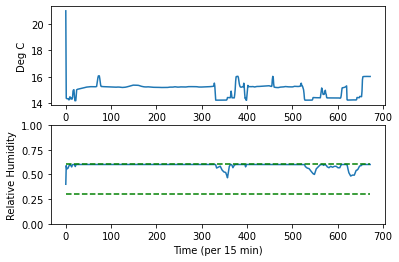

In [8]:
plt.subplot(2,1,1)
plt.plot(t,Troom1)
plt.ylabel('Deg C')
plt.subplot(2,1,2)
plt.plot(t,RH1)
plt.ylabel('Relative Humidity')
plt.xlabel('Time (per 15 min)')
plt.plot(t,upper_lim,'g--')
plt.plot(t,lower_lim,'g--')
plt.ylim([0,1])

(0.0, 1.0)

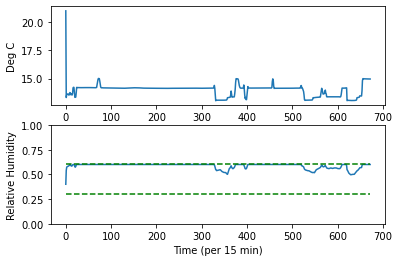

In [9]:
plt.subplot(2,1,1)
plt.plot(t,Troom2)
plt.ylabel('Deg C')
plt.subplot(2,1,2)
plt.plot(t,RH2)
plt.ylabel('Relative Humidity')
plt.xlabel('Time (per 15 min)')
plt.plot(t,upper_lim,'g--')
plt.plot(t,lower_lim,'g--')
plt.ylim([0,1])

(0.0, 1.0)

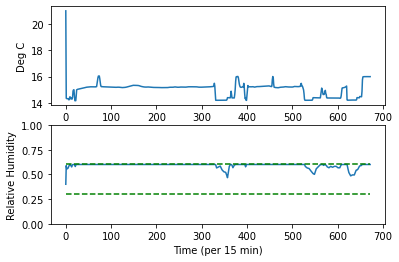

In [10]:
plt.subplot(2,1,1)
plt.plot(t,Troom3)
plt.ylabel('Deg C')
plt.subplot(2,1,2)
plt.plot(t,RH3)
plt.ylabel('Relative Humidity')
plt.xlabel('Time (per 15 min)')
plt.plot(t,upper_lim,'g--')
plt.plot(t,lower_lim,'g--')
plt.ylim([0,1])

(0.0, 1.0)

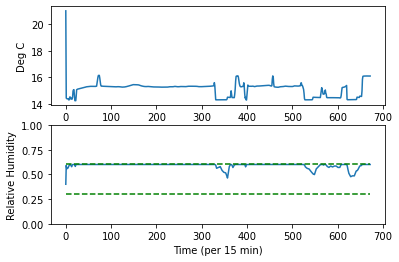

In [11]:
plt.subplot(2,1,1)
plt.plot(t,Troom4)
plt.ylabel('Deg C')
plt.subplot(2,1,2)
plt.plot(t,RH4)
plt.ylabel('Relative Humidity')
plt.xlabel('Time (per 15 min)')
plt.plot(t,upper_lim,'g--')
plt.plot(t,lower_lim,'g--')
plt.ylim([0,1])

(0.0, 1.0)

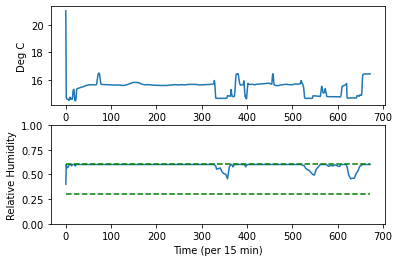

In [12]:
plt.subplot(2,1,1)
plt.plot(t,Troom5)
plt.ylabel('Deg C')
plt.subplot(2,1,2)
plt.plot(t,RH5)
plt.ylabel('Relative Humidity')
plt.xlabel('Time (per 15 min)')
plt.plot(t,upper_lim,'g--')
plt.plot(t,lower_lim,'g--')
plt.ylim([0,1])

# Violation Calculation

In [13]:
meanRHvio = np.zeros((5,1))
meanTvio = np.zeros((5,1))
for j in range(5):
    T_vio = 0
    RH_vio = 0
    for i in range(simHorizon):
        if x[j+1,i] < 15 or x[j+1,i] > 25:
            T_vio += 1
        if x[j-5,i] > 0.6 or x[j-5,i] < 0.3:
            RH_vio += 1
    meanRHvio[j] = RH_vio / simHorizon
    meanTvio[j] = T_vio / simHorizon

In [14]:
meanTvio

array([[0.27934621],
       [0.99702823],
       [0.28528975],
       [0.27637444],
       [0.24814264]])

In [15]:
meanRHvio

array([[0.72511144],
       [0.7013373 ],
       [0.73699851],
       [0.73699851],
       [0.7473997 ]])

In [16]:
meanRHvio.mean()

0.7295690936106983

In [17]:
ACheat = U[:2,:]
ACheat.mean()

115.1481688754129

In [18]:
De_H_umidifier = U[2:,:]
De_H_umidifier.mean()

52.36989046340356

In [19]:
U.mean()

61.338215950833465

In [20]:
df = pd.DataFrame(x)
df.to_excel(excel_writer = r"C:\Users\13905\Desktop\Research\Humidity Model\Determinisic.xlsx")    

In [21]:
(end - start) / simHorizon

0.05015656356471432

In [22]:
sum(U.mean(axis=1))

858.7350233116684

In [23]:
meanRHvio.mean()

0.7295690936106983

In [24]:
meanTvio.mean()

0.41723625557206534

In [25]:
error

0